In [1]:
from configparser import ConfigParser
from os.path import expanduser
import psycopg
from sqlalchemy import create_engine, text as sql_text
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Nom de la connexion à recherche dans le fichier de configuration (databases.ini sous $HOME)
SECTION = "inventaire-local"
# Nom du schéma à interroger
SCHEMA = "inv_exp_nm"

In [3]:
def config(section = 'inventaire-local', filename = expanduser("~") + '/databases.ini'):
    """Fonction retournant les informations de chaîne de connexion à une base de données PostgreSQL à partir d'un fichier de configuration.
    Les paramètres sont :
        * section : nom de la section (entre crochets) à lire dans le fichier databases.ini. Par défaut, la connexion se nomme inventaire-local.
        * filename : chemin complet vers le fichier de configuration. Par défaut, le fichier se nomme databases.ini dans le répertoire home de l'utilisateur"""
    # Création d'un parseur
    parser = ConfigParser()
    # Lecture du fichier de configuration
    parser.read(filename)

    # Récupération de la section passée en paramètre ("confinement" par défaut)
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception(f'Section {section} absente du fichier {filename}')

    return db

In [4]:
# Récupération des paramètres de connexion
params = config(SECTION)

# Connexion à la base de données (sortie du programme en cas d'échec)
conn = None
try:
    url = f"postgresql+psycopg://{params['user']}@{params['host']}:5432/{params['dbname']}"
    print(url)
    engine = create_engine(url)
except Exception as e:
    print(f"Impossible de se connecter à {params['dbname']}, {e}")
if engine is None:
    sys.exit("Pas de connexion à la base de données, programme interrompu.")

# Serveur de bases de données
SERVEUR = params['host']
# Nom de la base de données
DATABASE = params['dbname']
# Nom de compte connecté à la base de données
USER = params['user']

postgresql+psycopg://administrateur@localhost:5432/inventaire


## Test sur CSP1

In [5]:
req = f"""SELECT p1.incref + 2005 AS campagne, csp1::TEXT, coalesce(SUM(ue.poids), 0)::INT AS eff_pond
FROM {SCHEMA}.e1point p1
INNER JOIN {SCHEMA}.unite_ech ue ON p1.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE1POINT'
GROUP BY campagne, csp1
ORDER BY campagne DESC
"""

In [6]:
#df = pd.read_sql_query(req,con=conn)
#with engine.connect().execution_options(autocommit=True) as conn:
#    query = conn.execute(text(req))
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,csp1,eff_pond
0,2022,5,166
1,2022,7,3490
2,2022,1,17518
3,2022,2,691
4,2022,6,30495


In [12]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'CSP'
ORDER BY mode"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta.head()

,mode,libelle
0,0,Occulte
1,1,Couverture boisee fermee
2,2,Bosquet
3,3,Couverture boisee ouverte
4,4,Lande


In [13]:
meta["libelle"][0]

'Occulte'

In [14]:
reshaped_df = df.pivot(index='campagne', columns='csp1', values='eff_pond')
reshaped_df

csp1,0,1,2,3,4,5,6,7,9
campagne,,,,,,,,,
2005,70,14763,310,1373,2994,246,29532,5000,636
2006,72,14968,236,1286,2876,203,30609,4067,664
2007,76,15119,292,1082,2907,210,30637,4004,640
2008,70,15498,314,1176,2541,219,30579,3851,706
2009,72,15844,379,913,2746,212,30101,3949,702
2010,74,15897,352,939,2623,220,30371,3806,646
2011,59,15937,369,1013,2559,212,30162,3979,661
2012,60,16197,350,922,2628,220,30083,3774,704
2013,51,16497,308,955,2600,198,29907,3716,727


In [19]:
reshaped_df.index

Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
            2016, 2017, 2018, 2019, 2020, 2021, 2022],
           dtype='int64', name='campagne')

In [13]:
list(meta["libelle"].values)

['Occulte',
 'Couverture boisee fermee',
 'Bosquet',
 'Couverture boisee ouverte',
 'Lande',
 'Peupleraie',
 'Autre vegetation',
 'Sans vegetation',
 'Eau continentale']

In [14]:
list(mcolors.TABLEAU_COLORS)[0]

'tab:blue'

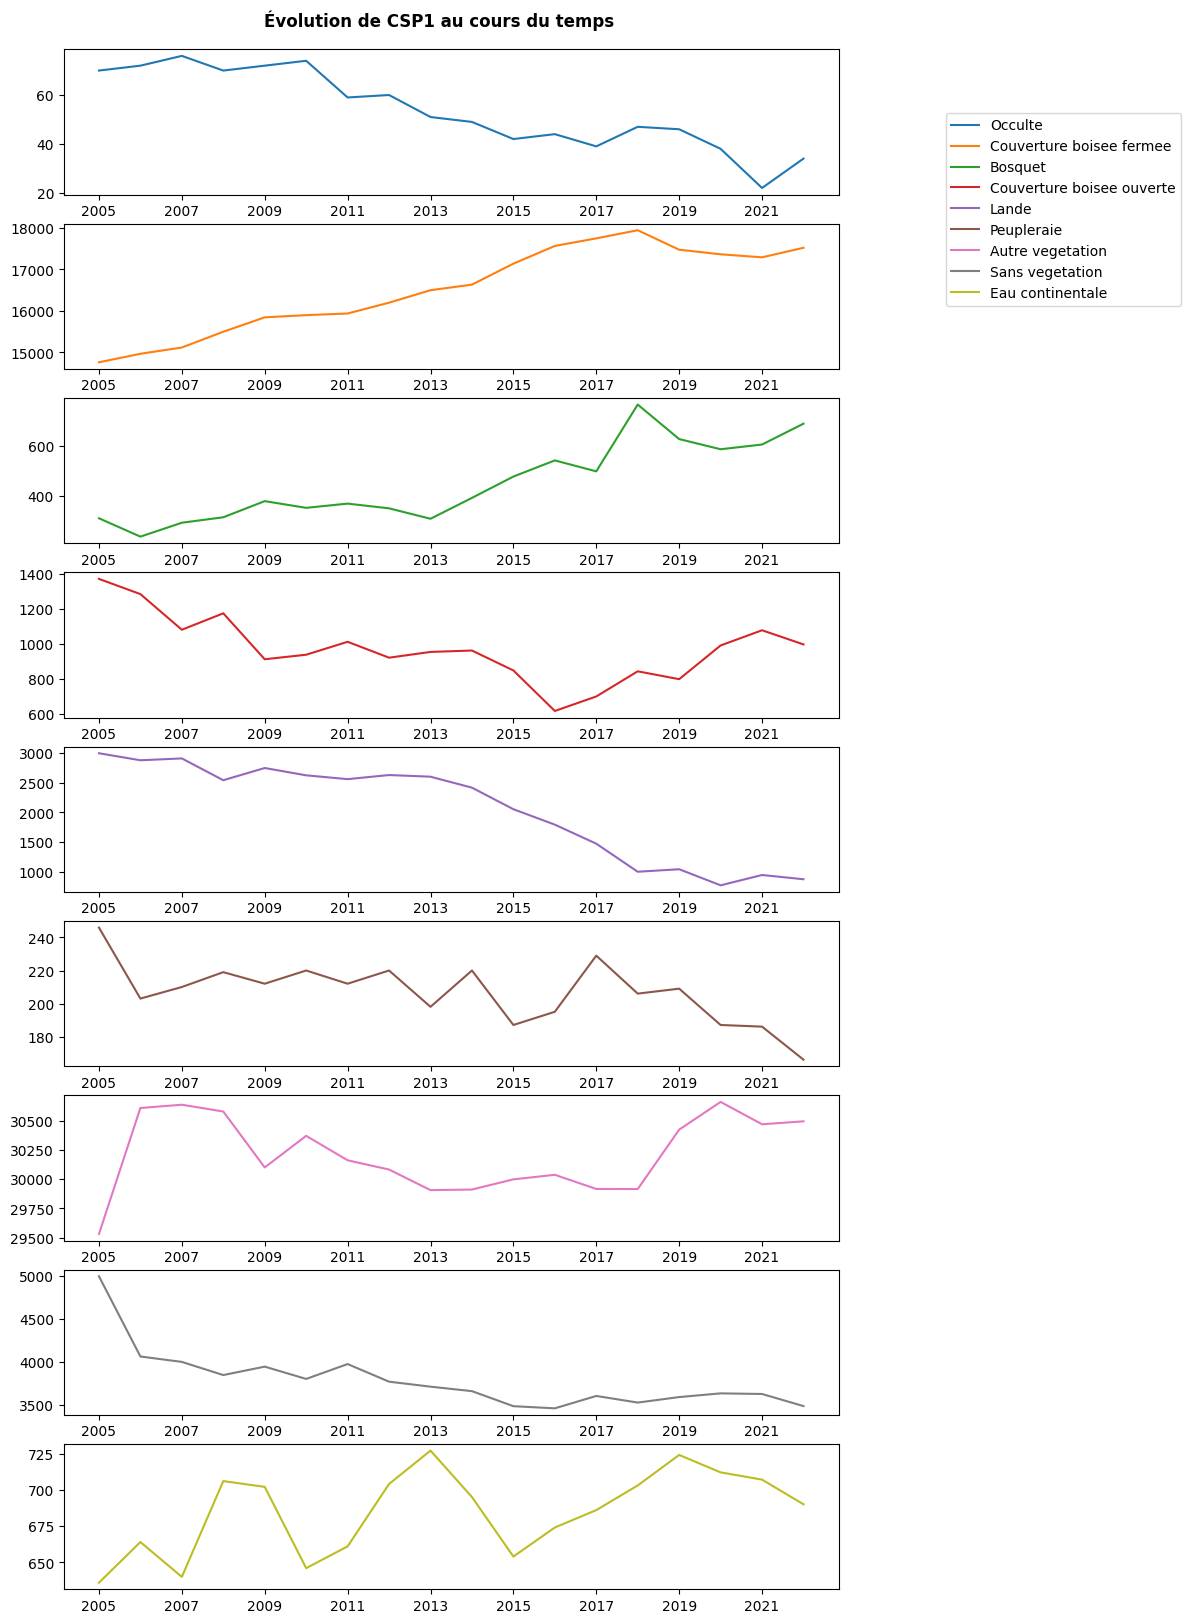

In [23]:
fig = plt.figure(1, figsize=(10, 20))
for k in range(len(reshaped_df.columns)):
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns.to_list()[k]], label=list(meta["libelle"].values)[k], color=list(mcolors.TABLEAU_COLORS)[k])      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de CSP1 au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur CSP2

In [8]:
req = f"""SELECT p2.incref + 2005 AS campagne, csp2::TEXT, SUM(ue.poids)::INT AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
GROUP BY campagne, csp2
ORDER BY campagne DESC
"""

In [9]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,csp2,eff_pond
0,2022,0,34
1,2022,1,17155
2,2022,2,323
3,2022,3,858
4,2022,4,618


In [10]:
reshaped_df = df.pivot(index='campagne', columns='csp2', values='eff_pond')
reshaped_df

csp2,0,1,2,3,4,5,6,7,9
campagne,,,,,,,,,
2005,70,14319,206,1675,2385,186,30132,5097,685
2006,72,14415,178,1254,2491,184,30919,4362,727
2007,76,14968,192,1362,2189,237,31635,4221,719
2008,70,15153,189,1070,2263,205,31525,4060,712
2009,72,15426,238,958,2298,169,30983,4222,812
2010,74,15464,251,969,2204,180,31339,3968,695
2011,59,15683,288,872,2164,186,31056,4208,769
2012,60,15704,236,947,2189,216,31052,4110,754
2013,51,16044,215,947,2102,167,30671,4054,824


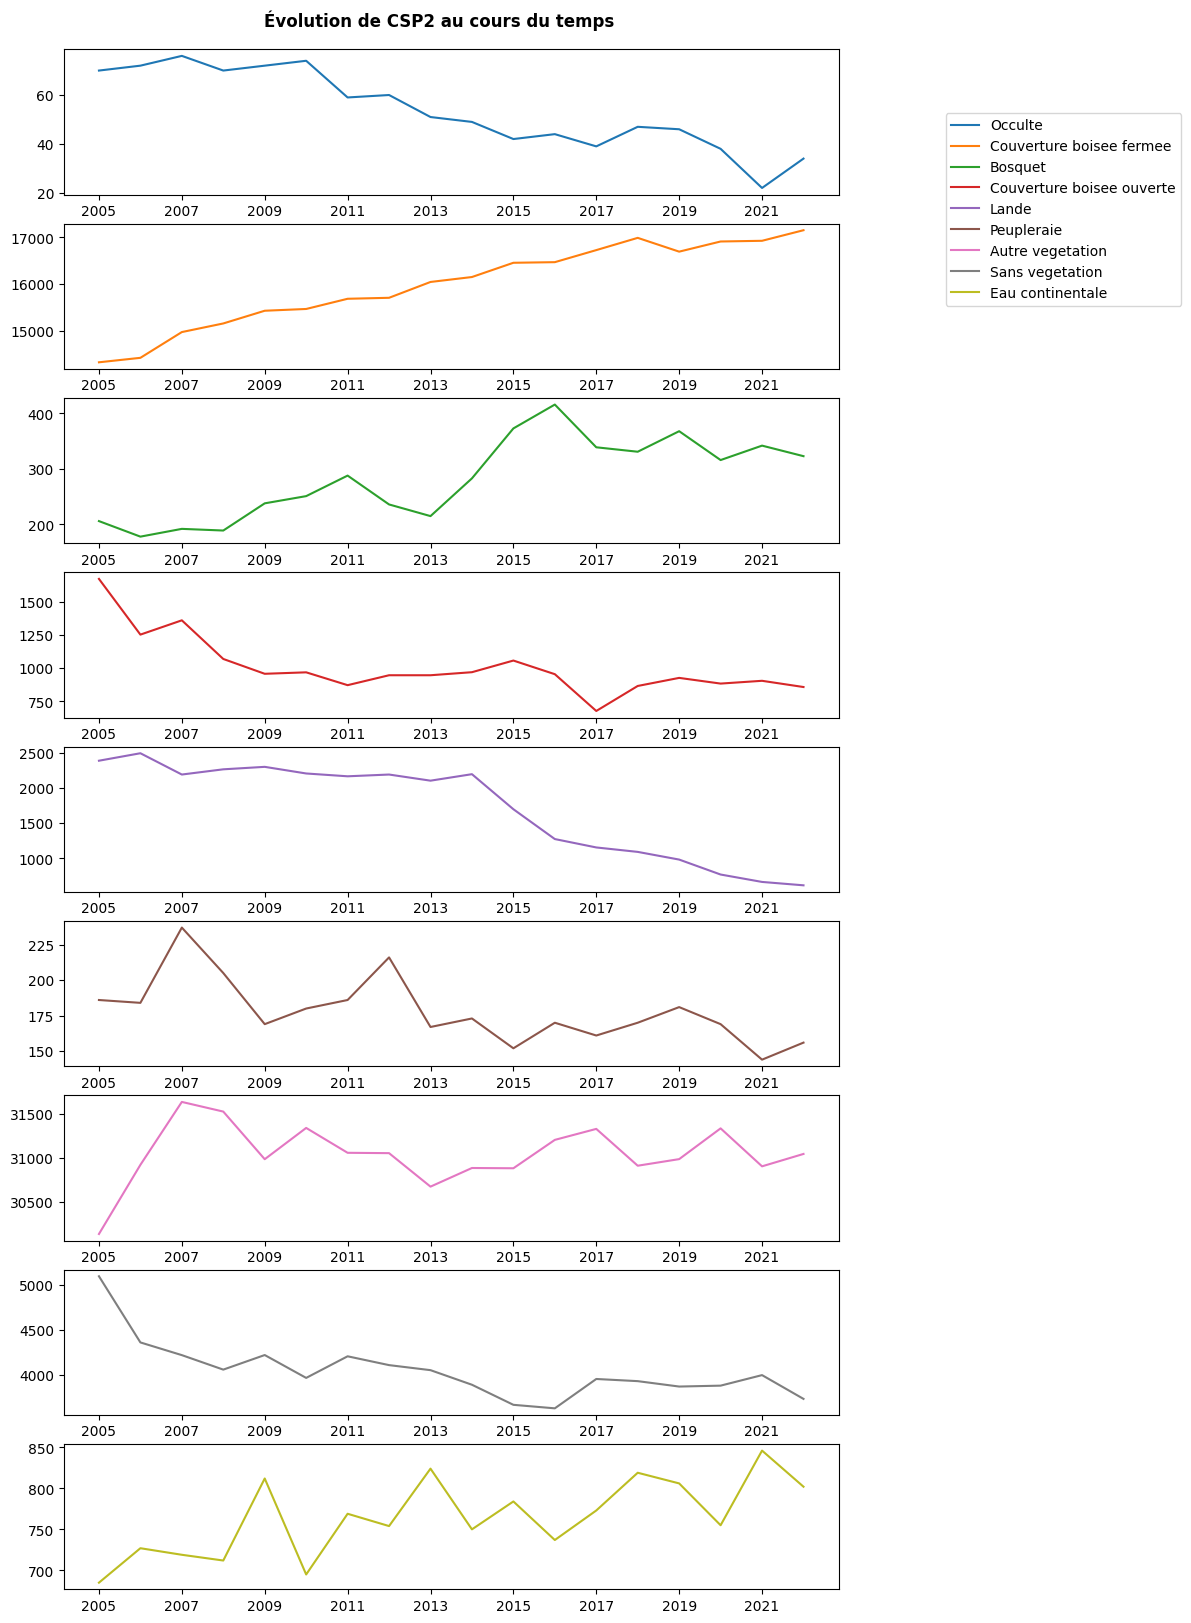

In [14]:
fig = plt.figure(1, figsize=(10, 20))
for k in range(len(reshaped_df.columns)):
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns.to_list()[k]], label=list(meta["libelle"].values)[k], color=list(mcolors.TABLEAU_COLORS)[k])      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de CSP2 au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur US_NM

In [15]:
req = f"""SELECT p2.incref + 2005 as campagne, COALESCE(p2.us_nm, 'X') AS us_nm, ROUND(SUM(ue.poids)::NUMERIC, 1) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
GROUP BY p2.incref, us_nm
ORDER BY p2.incref DESC, us_nm
"""

In [16]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,us_nm,eff_pond
0,2022,0,34.0
1,2022,1,16479.5
2,2022,2,898.1
3,2022,3,206.9
4,2022,4,618.3


In [17]:
reshaped_df = df.pivot(index='campagne', columns='us_nm', values='eff_pond')
reshaped_df

us_nm,0,1,2,3,4,5,6,7,8,A
campagne,,,,,,,,,,
2005,70.0,15175.9,818.4,103.5,2384.8,186.0,30132.1,5097.3,685.2,102.8
2006,72.0,14659.8,649.8,110.6,2491.1,184.0,31277.8,4361.9,726.5,67.6
2007,76.3,15240.5,793.4,110.1,2189.1,235.9,31931.9,4221.5,719.2,81.6
2008,70.3,15150.5,759.9,97.1,2262.8,204.0,31839.0,4060.0,711.8,92.4
2009,71.8,15224.2,788.2,120.7,2297.6,168.4,31355.1,4221.9,812.3,117.4
2010,74.0,15397.7,717.5,142.5,2204.5,179.5,31658.2,3968.1,694.8,108.5
2011,59.3,15346.5,833.8,179.0,2164.5,184.0,31431.8,4208.0,769.2,108.8
2012,60.0,15362.0,888.8,117.0,2188.8,213.5,31454.2,4109.6,754.1,118.5
2013,50.8,15828.4,800.7,96.0,2102.3,165.7,31034.2,4054.1,824.4,119.0


In [18]:
reshaped_df.to_clipboard(excel = True, decimal = ',') # nécessite d'installer xclip sous Linux

In [19]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'CSUTTM'
UNION
SELECT 'X', 'Occulté'
ORDER BY mode
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,0,Occulté
1,1,Forêt de production hors peupleraie
2,2,Autre forêt
3,3,Bosquet de production
4,4,Lande
5,5,Peupleraie
6,6,Autre végétation
7,7,Improductif
8,8,Eau
9,9,Hors territoire


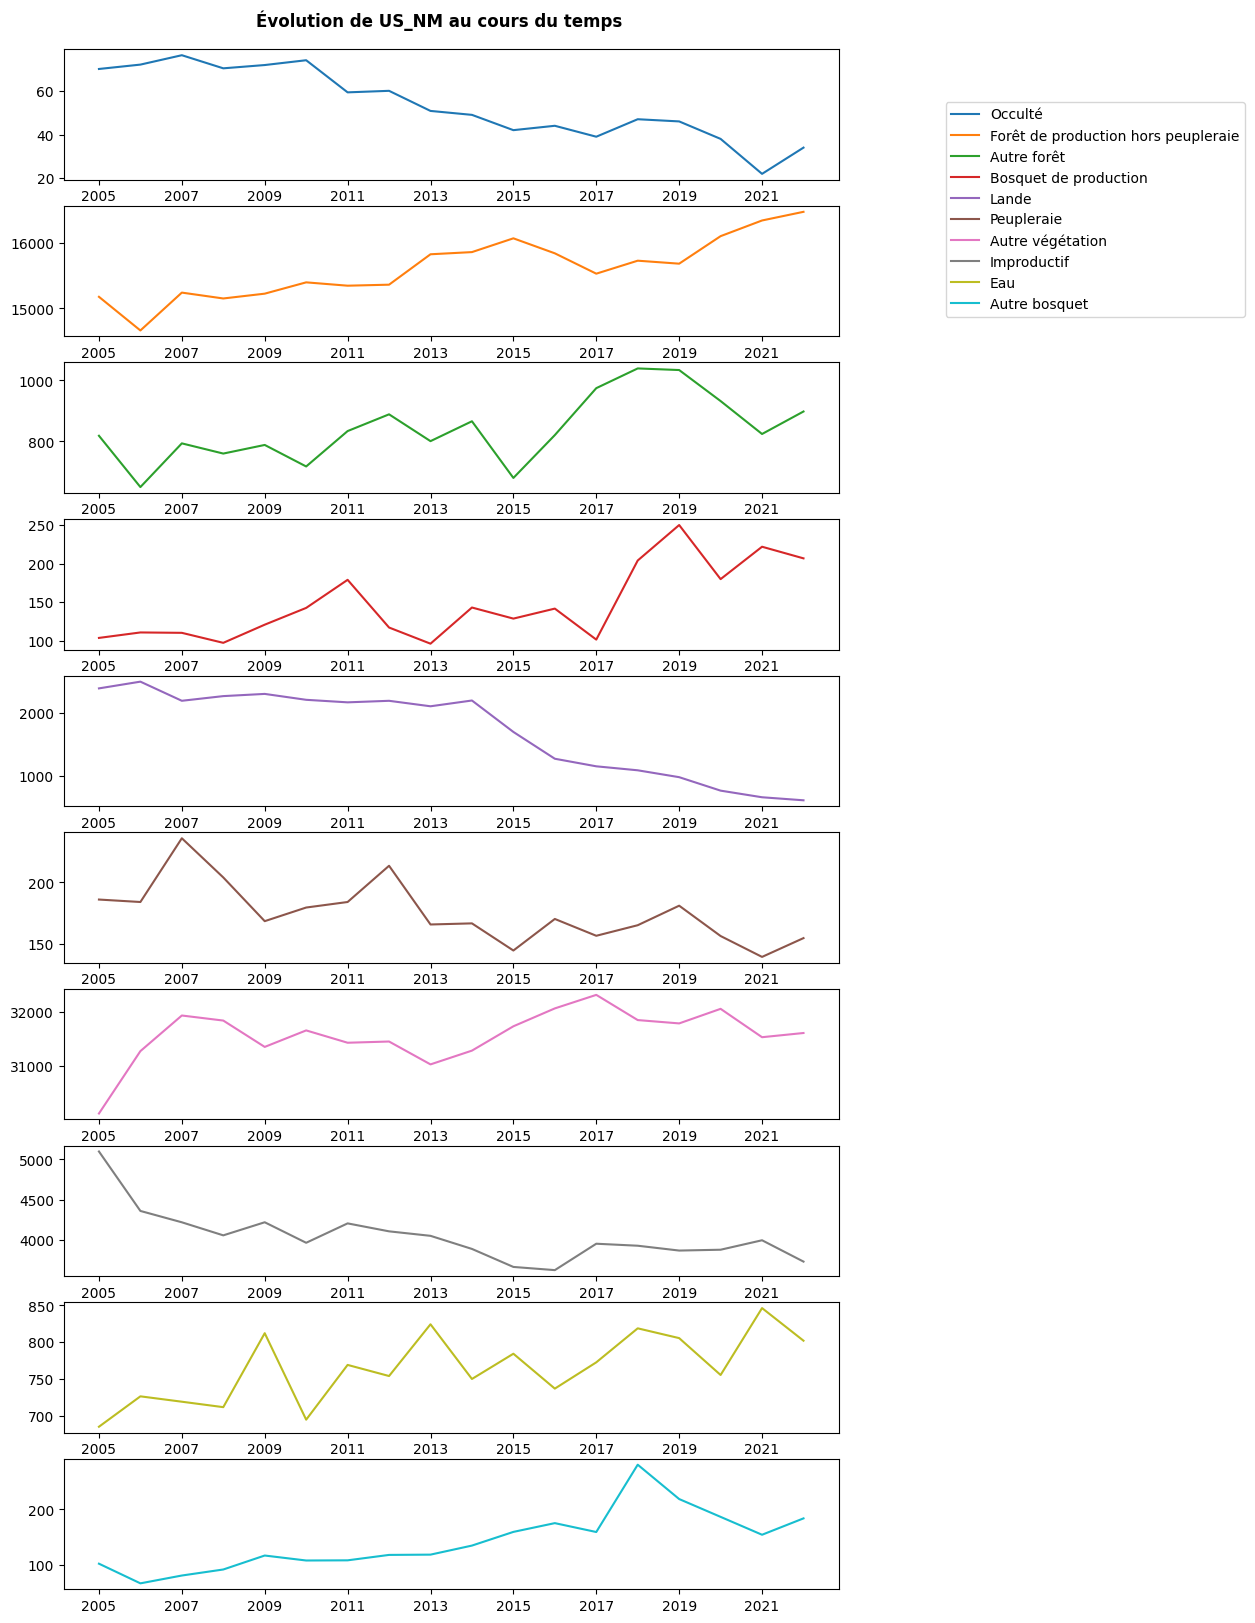

In [20]:
fig = plt.figure(1, figsize=(10, 20))
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=list(mcolors.TABLEAU_COLORS)[k])      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de US_NM au cours du temps", y=0.9, fontweight='bold')
plt.show()

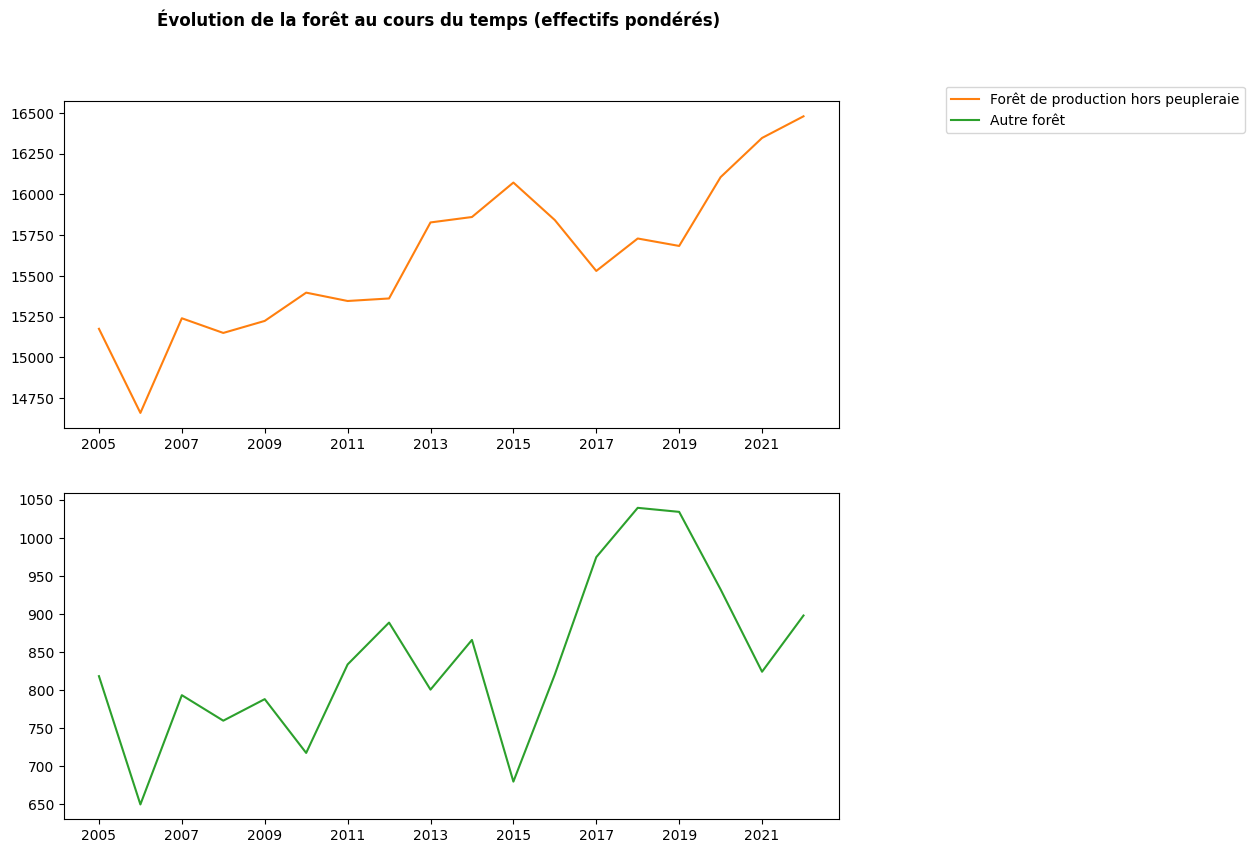

In [21]:
fig = plt.figure(1, figsize=(10, 50))
for k in [1,2]:
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=list(mcolors.TABLEAU_COLORS)[k])      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de la forêt au cours du temps (effectifs pondérés)", y=0.82, fontweight='bold')
plt.show()

# Test sur EXPN

In [22]:
req = f"""SELECT f.incref + 2005 AS campagne, f.expl, ROUND(sum(ue.poids)::NUMERIC, 2) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
INNER JOIN {SCHEMA}.g3foret f USING (npp)
WHERE p2.us_nm IN ('1', '5') AND f.incref >= 3
GROUP BY f.incref, f.expl
ORDER BY campagne DESC, expl
"""

In [23]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,expl,eff_pond
0,2022,0,4674.33
1,2022,1,4617.16
2,2022,2,1464.55
3,2022,3,5609.71
4,2021,0,4704.25


In [24]:
reshaped_df = df.pivot(index='campagne', columns='expl', values='eff_pond')
reshaped_df

expl,0,1,2,3
campagne,,,,
2008,4590.10,4281.07,1361.73,4917.58
2009,4417.88,4490.30,1311.23,5004.84
2010,4324.50,4765.17,1358.50,4949.50
2011,4814.50,4453.00,1278.00,4801.00
2012,4505.50,4582.50,1263.00,5011.00
2013,4789.42,4466.67,1240.02,5332.27
2014,4562.95,4351.83,1304.70,5642.26
2015,4777.45,4427.58,1381.53,5464.68
2016,4958.13,4339.21,1225.96,5275.25


In [25]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'EXPL'
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,0,Très facile
1,1,Facile
2,2,Moyenne
3,3,Difficile


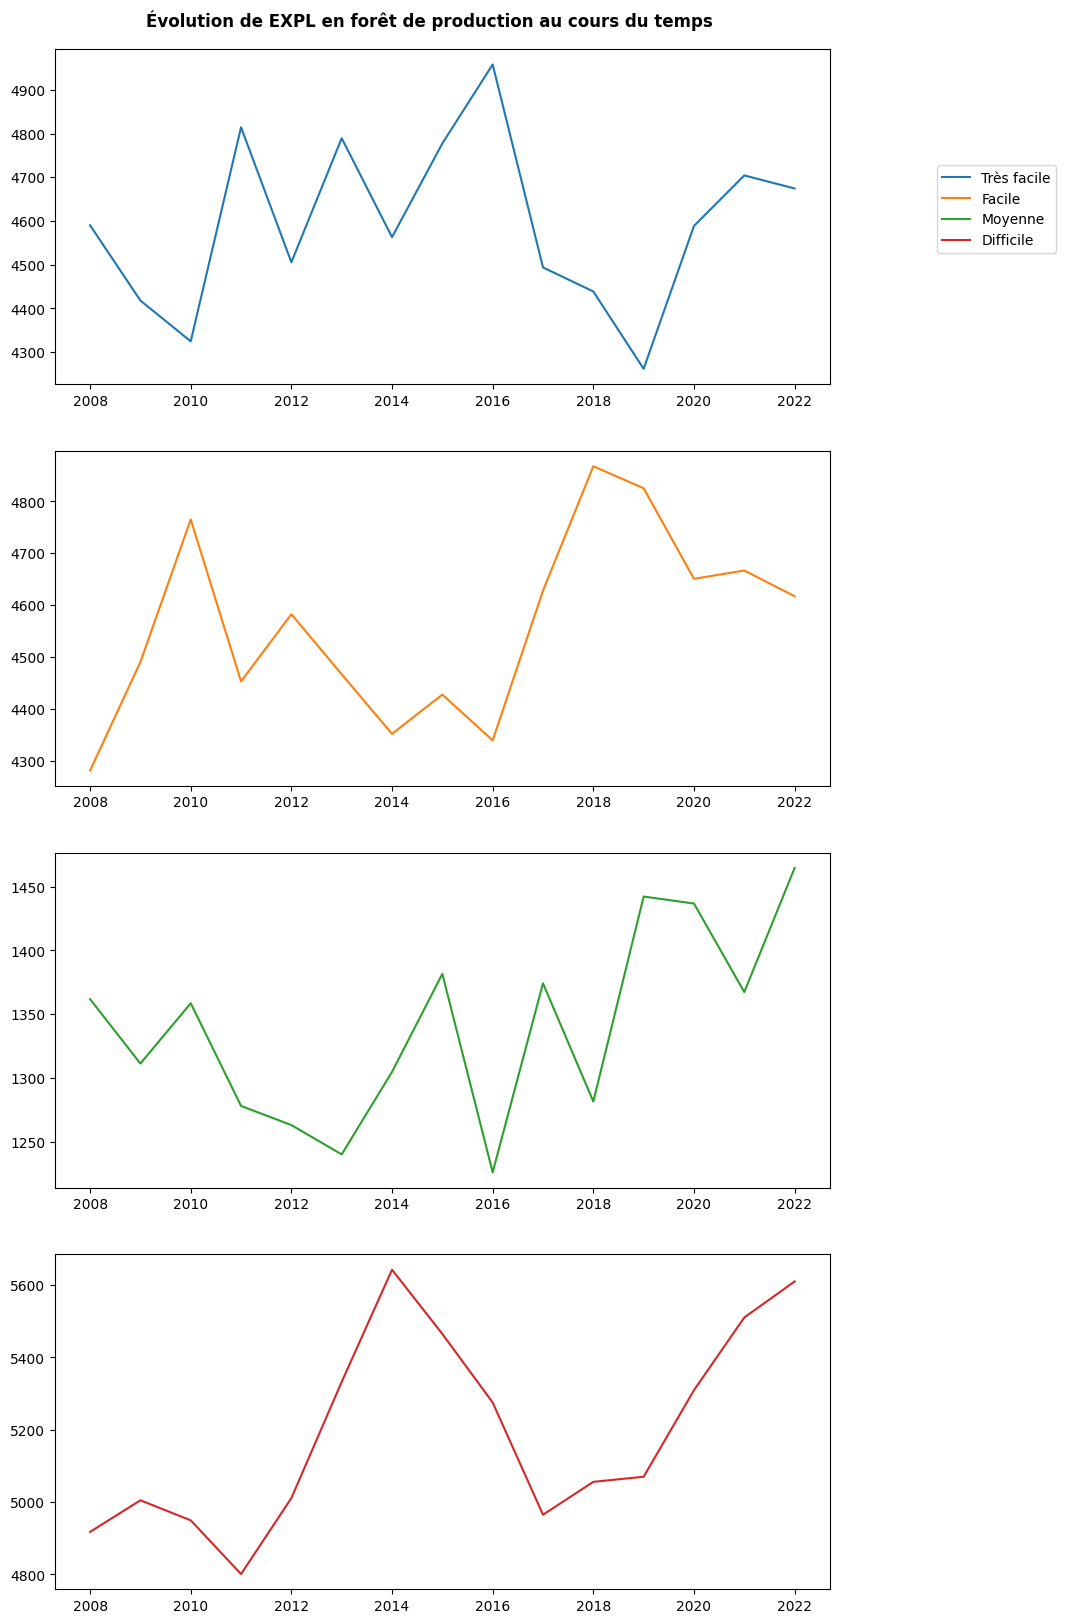

In [26]:
fig = plt.figure(1, figsize=(10, 20))
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=list(mcolors.TABLEAU_COLORS)[k])      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de EXPL en forêt de production au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur réserve utile

In [27]:
req = f"""SELECT f.incref + 2005 AS campagne, RTRIM(f.rut) AS ruti, SUM(ue.poids) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
INNER JOIN {SCHEMA}.g3ecologie f USING (npp)
WHERE p2.us_nm = '1'
AND f.incref >= 3
GROUP BY f.incref, ruti
ORDER BY f.incref DESC, ruti
"""

In [28]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,ruti,eff_pond
0,2022,1,284.636355
1,2022,10,151.272722
2,2022,2,2097.745391
3,2022,3,3173.236265
4,2022,4,3029.799904


In [29]:
reshaped_df = df.pivot(index='campagne', columns='ruti', values='eff_pond')
reshaped_df['X'] = reshaped_df['X'].fillna(0)
reshaped_df

ruti,1,10,2,3,4,5,6,7,8,9,X
campagne,,,,,,,,,,,
2008,230.413793,180.224138,1764.623873,2674.400000,3110.039788,1770.198939,1481.763926,1102.986737,1199.435013,1636.387268,0.000000
2009,225.061008,189.161804,1685.836870,2797.594164,3316.332891,1877.900531,1337.050398,1079.805040,1036.702918,1672.183024,6.620690
2010,222.000000,249.500000,1748.500000,2649.500000,3079.500000,1874.000000,1557.500000,1116.500000,1146.500000,1750.166667,4.000000
2011,258.500000,259.500000,1890.000000,2738.500000,3191.000000,1719.000000,1505.500000,1057.000000,1113.000000,1602.500000,12.000000
2012,294.000000,232.000000,1986.000000,2666.000000,3217.500000,1726.000000,1398.500000,1072.000000,1084.000000,1686.000000,0.000000
2013,355.883287,266.913787,1873.251967,2989.273168,3058.209492,1747.311637,1447.018539,987.587511,1206.017214,1892.499957,4.413793
2014,312.301891,226.273588,1928.046748,3053.531491,3151.832032,1674.209369,1310.320774,1004.113222,1267.179264,1926.688707,7.245283
2015,313.735853,260.169815,1963.698141,3218.717028,3132.000046,1798.188705,1367.207567,1011.188694,1231.792471,1725.566063,28.981133
2016,290.415098,160.396229,2038.717010,3268.943443,3104.679291,1811.754744,1294.924547,954.811335,1139.264168,1688.754742,45.886793


In [30]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'RUT'
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,5,70 mm <= réserve utile < 90 mm
1,3,30 mm <= réserve utile < 50 mm
2,4,50 mm <= réserve utile < 70 mm
3,6,90 mm <= réserve utile < 110 mm
4,7,110 mm <= réserve utile < 130 mm
5,8,130 mm <= réserve utile < 150 mm
6,9,150 mm <= réserve utile < 170 mm
7,10,170 mm <= réserve utile < 190 mm
8,11,Réserve utile >= 190 mm
9,X,Réserve utile indéterminée


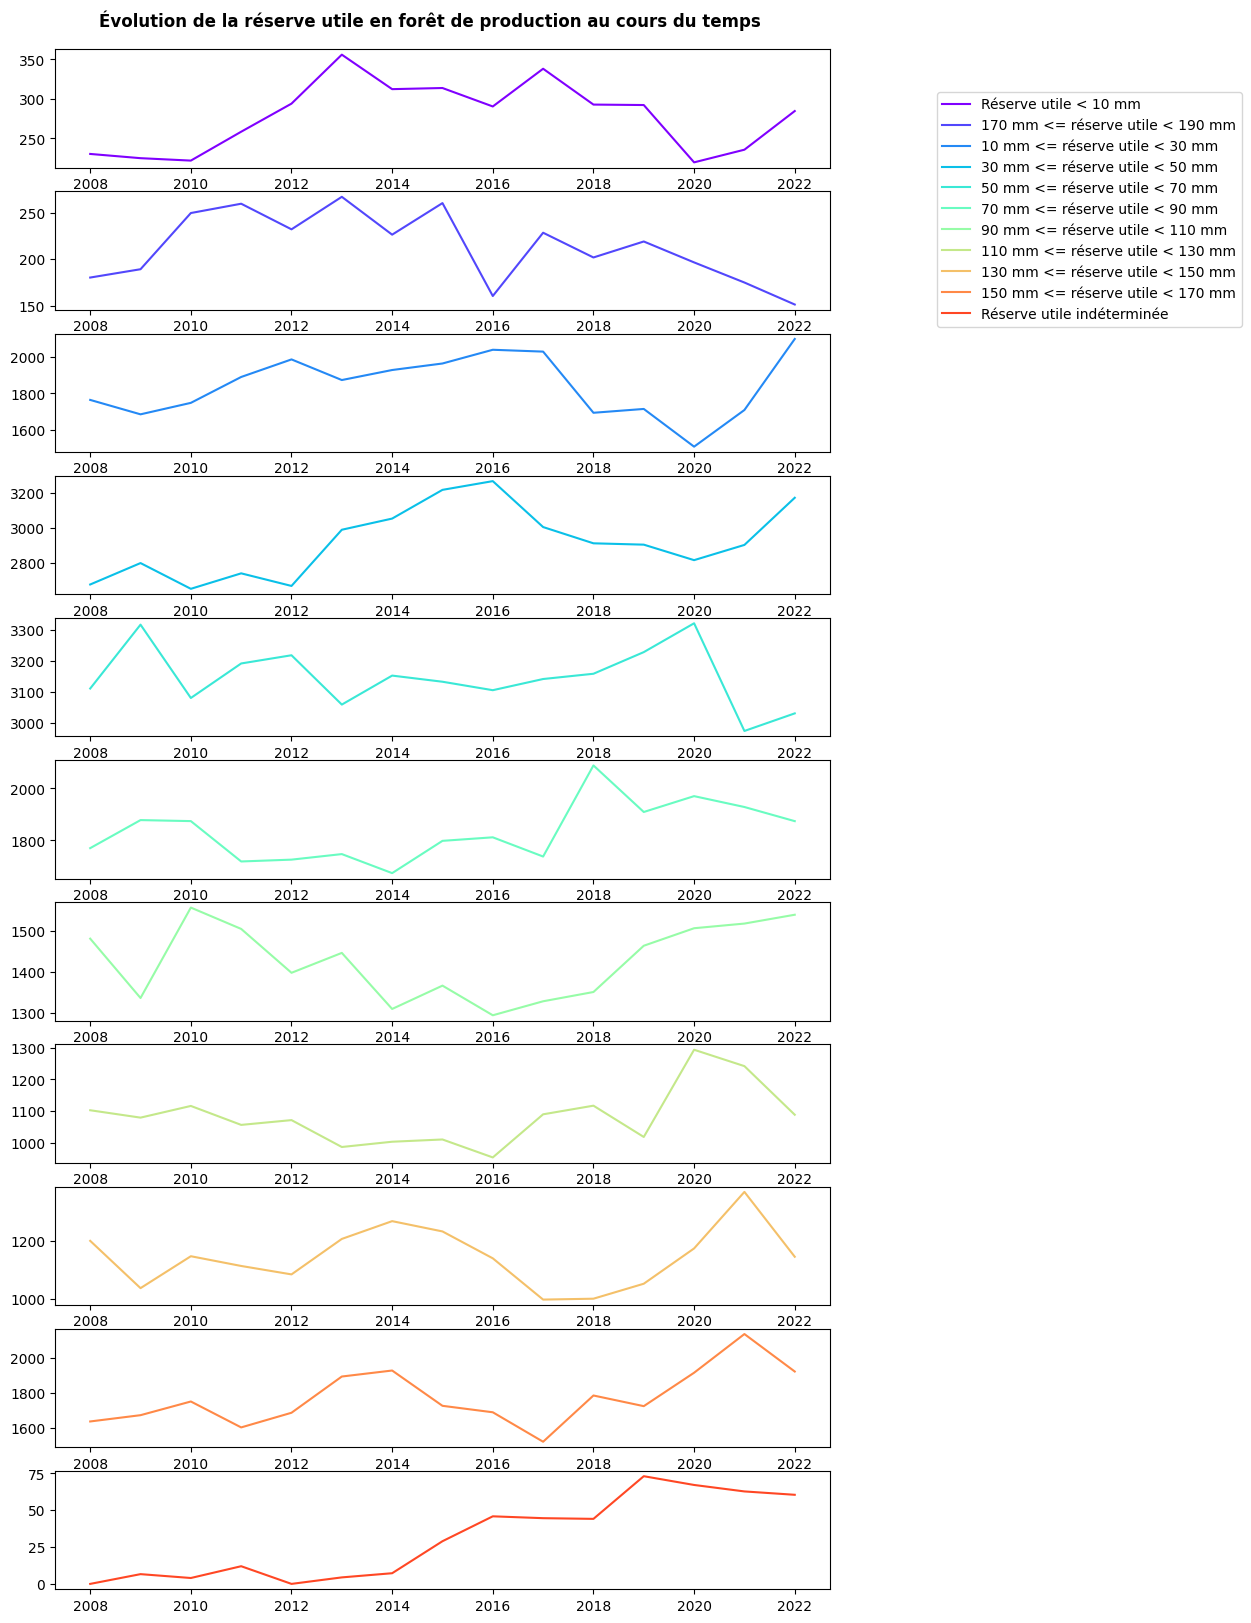

In [31]:
fig = plt.figure(1, figsize=(10, 20))
cm = plt.cm.rainbow
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
    ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de la réserve utile en forêt de production au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur le niveau trophique

In [32]:
req = f"""SELECT f.incref + 2005 AS campagne, coalesce(RTRIM(f.troph), 'X') AS trophi, SUM(ue.poids) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
INNER JOIN {SCHEMA}.g3ecologie f USING (npp)
WHERE p2.us_nm = '1'
AND f.incref >= 3
GROUP BY f.incref, trophi
ORDER BY f.incref DESC, trophi
"""

In [33]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,trophi,eff_pond
0,2022,1,209.454539
1,2022,10,1945.527214
2,2022,11,4.654545
3,2022,2,1609.818131
4,2022,3,2916.799908


In [34]:
reshaped_df = df.pivot(index='campagne', columns='trophi', values='eff_pond')
reshaped_df

trophi,1,10,11,2,3,4,5,6,7,8,9,X
campagne,,,,,,,,,,,,
2008,223.437666,1485.797082,20.116711,1747.374005,2789.190451,2118.655703,1373.911141,1103.086207,1187.392573,1528.704244,1567.893899,4.913793
2009,207.872679,1563.704244,13.336870,1745.798408,2803.683024,2114.648541,1474.679045,1062.363395,1179.908488,1374.709549,1666.303714,17.241379
2010,288.000000,1506.500000,6.000000,1726.000000,2709.000000,2131.500000,1469.500000,1126.500000,1236.500000,1330.500000,1859.666667,8.000000
2011,268.000000,1456.500000,8.000000,1812.000000,2734.000000,2131.500000,1396.500000,1180.500000,1215.000000,1368.000000,1764.500000,12.000000
2012,238.000000,1560.000000,10.000000,1716.000000,2901.000000,1991.500000,1424.000000,1159.500000,1233.500000,1337.500000,1783.000000,8.000000
2013,264.827580,1651.120674,10.620690,1653.655136,2742.387215,2188.362032,1526.710846,1191.643214,1289.397853,1524.827557,1780.413762,4.413793
2014,214.113211,1809.056629,16.905661,1792.754744,2714.690067,2274.067419,1365.237666,1180.030116,1227.886810,1439.415115,1820.339649,7.245283
2015,217.358494,1862.037762,16.905661,1702.641535,2861.830231,2198.679277,1518.283041,1268.377377,1160.679262,1496.811342,1742.811346,4.830189
2016,207.698116,1672.377382,12.075472,1684.754742,2759.490606,2154.641541,1643.113232,1154.094357,1296.924547,1514.886814,1679.169836,19.320755


In [35]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'TROPH'
UNION
SELECT 'X', 'Non renseigné'
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,7,Mésoneutrophile
1,4,Mésoacidiphile
2,1,Hyperacidiphile
3,X,Non renseigné
4,9,Neutrocalcicole
5,5,Acidicline
6,10,Calcicole
7,3,Faiblement acidiphile
8,6,Neutroacidicline
9,2,Acidiphile


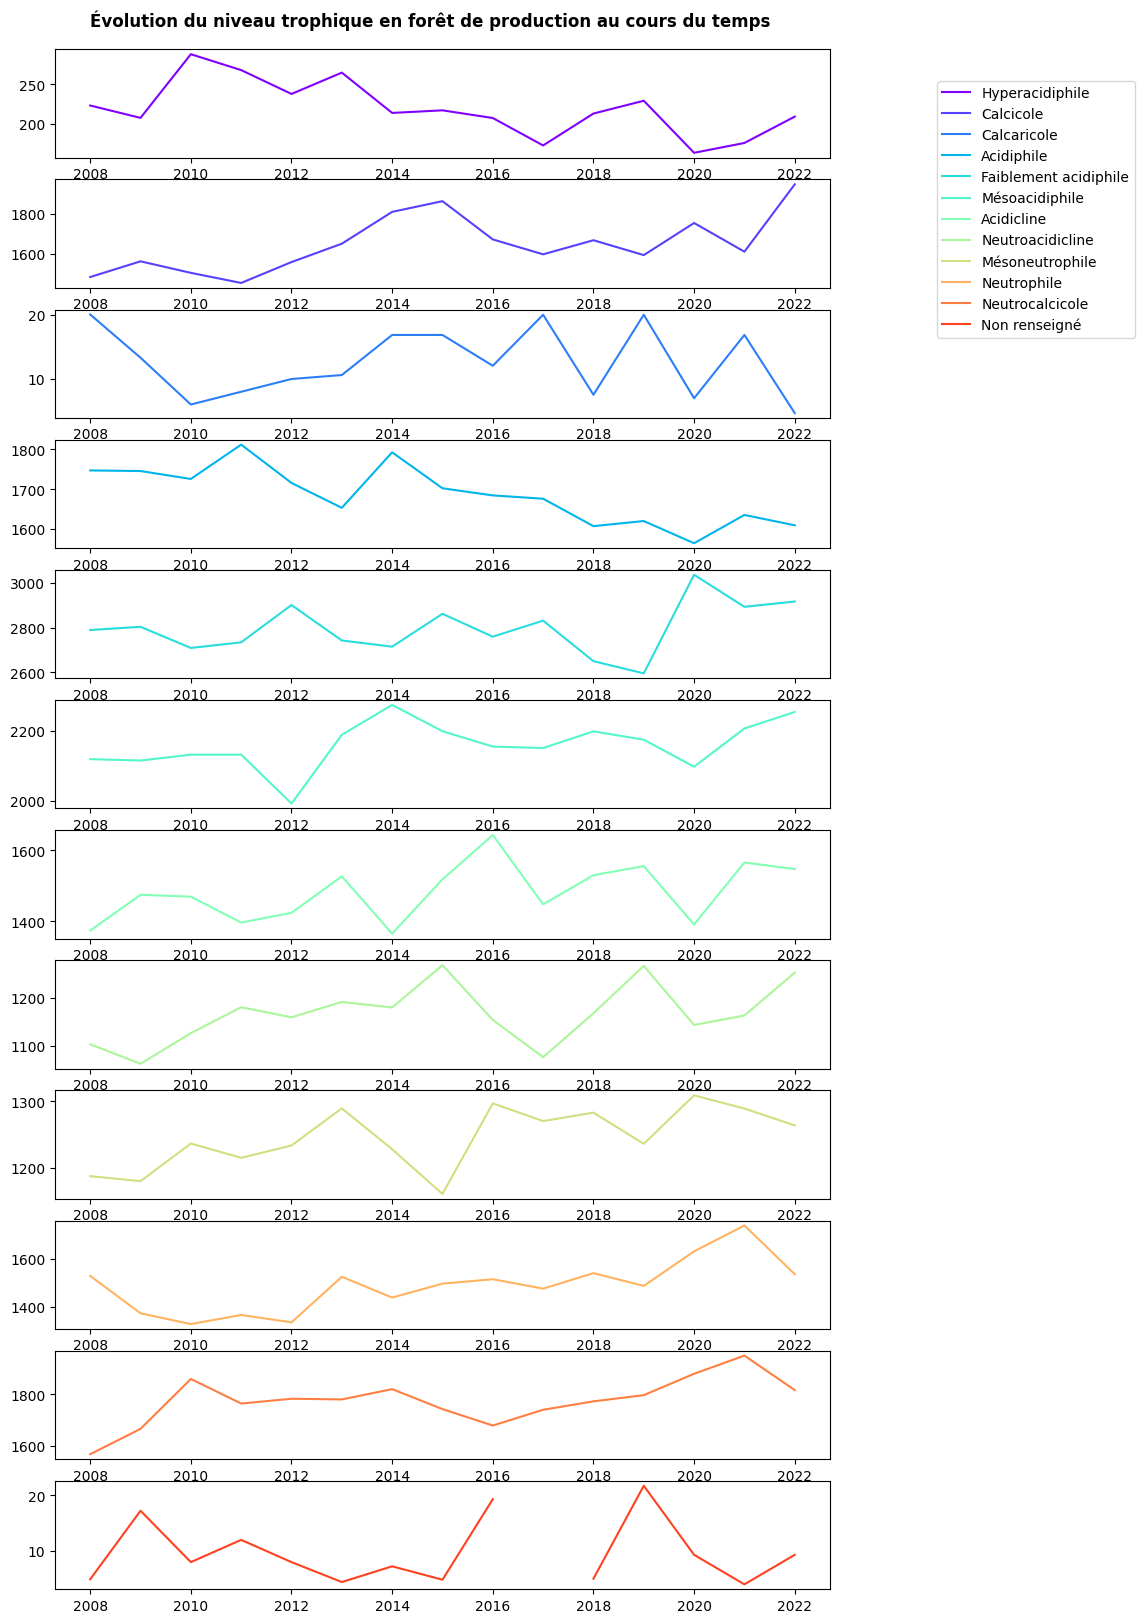

In [36]:
fig = plt.figure(1, figsize=(10, 20))
cm = plt.cm.rainbow
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
    ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du niveau trophique en forêt de production au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur le niveau hydrique

In [37]:
req = f"""SELECT f.incref + 2005 AS campagne, coalesce(RTRIM(f.hydr), 'X') AS hydri, SUM(ue.poids) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
INNER JOIN {SCHEMA}.g3ecologie f USING (npp)
WHERE p2.us_nm = '1'
AND f.incref >= 3
GROUP BY f.incref, hydri
ORDER BY f.incref DESC, hydri
"""

In [38]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,hydri,eff_pond
0,2022,1,39.563635
1,2022,2,764.054522
2,2022,3,2424.745378
3,2022,4,3692.436247
4,2022,5,3105.963539


In [39]:
reshaped_df = df.pivot(index='campagne', columns='hydri', values='eff_pond')
reshaped_df

hydri,1,2,3,4,5,6,7,8,9,X
campagne,,,,,,,,,,
2008,14.250663,764.037135,2714.240053,3153.420424,2748.119363,1775.428382,1227.225464,1449.479576,1299.358621,4.913793
2009,19.034483,721.006631,2770.350133,3337.355438,2764.001326,1697.116711,1092.116711,1494.822281,1311.204244,17.241379
2010,16.000000,723.500000,2537.166667,3125.000000,3105.000000,1872.500000,1180.000000,1488.500000,1342.000000,8.000000
2011,38.000000,835.500000,2610.000000,3191.000000,2882.000000,1906.000000,1212.000000,1396.000000,1264.000000,12.000000
2012,28.000000,698.500000,2613.000000,3179.000000,2929.000000,1874.500000,1304.000000,1452.000000,1276.000000,8.000000
2013,13.741379,737.948259,2795.017179,3299.137858,2924.501262,1842.448239,1245.899184,1574.578247,1390.694952,4.413793
2014,26.235849,751.783030,2775.150984,3360.490616,2986.726460,1831.066065,1248.643325,1505.681963,1368.718797,7.245283
2015,23.320755,873.622654,2523.377396,3283.301935,3142.641556,1995.471727,1197.660395,1514.566059,1492.452850,4.830189
2016,28.981133,764.603785,2606.434000,3307.698162,3155.132122,1849.735876,1217.811338,1348.905680,1499.924549,19.320755


In [40]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'HYDR'
UNION
SELECT 'X', 'Non renseigné'
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,X,Non renseigné
1,6,Mésophile sec
2,5,Mésophile frais
3,4,Mésohygrocline
4,10,Hyperxérophile
5,3,Hygrocline
6,0,Non codé
7,1,Hygrophile
8,9,Xérophile
9,8,Mésoxérophile


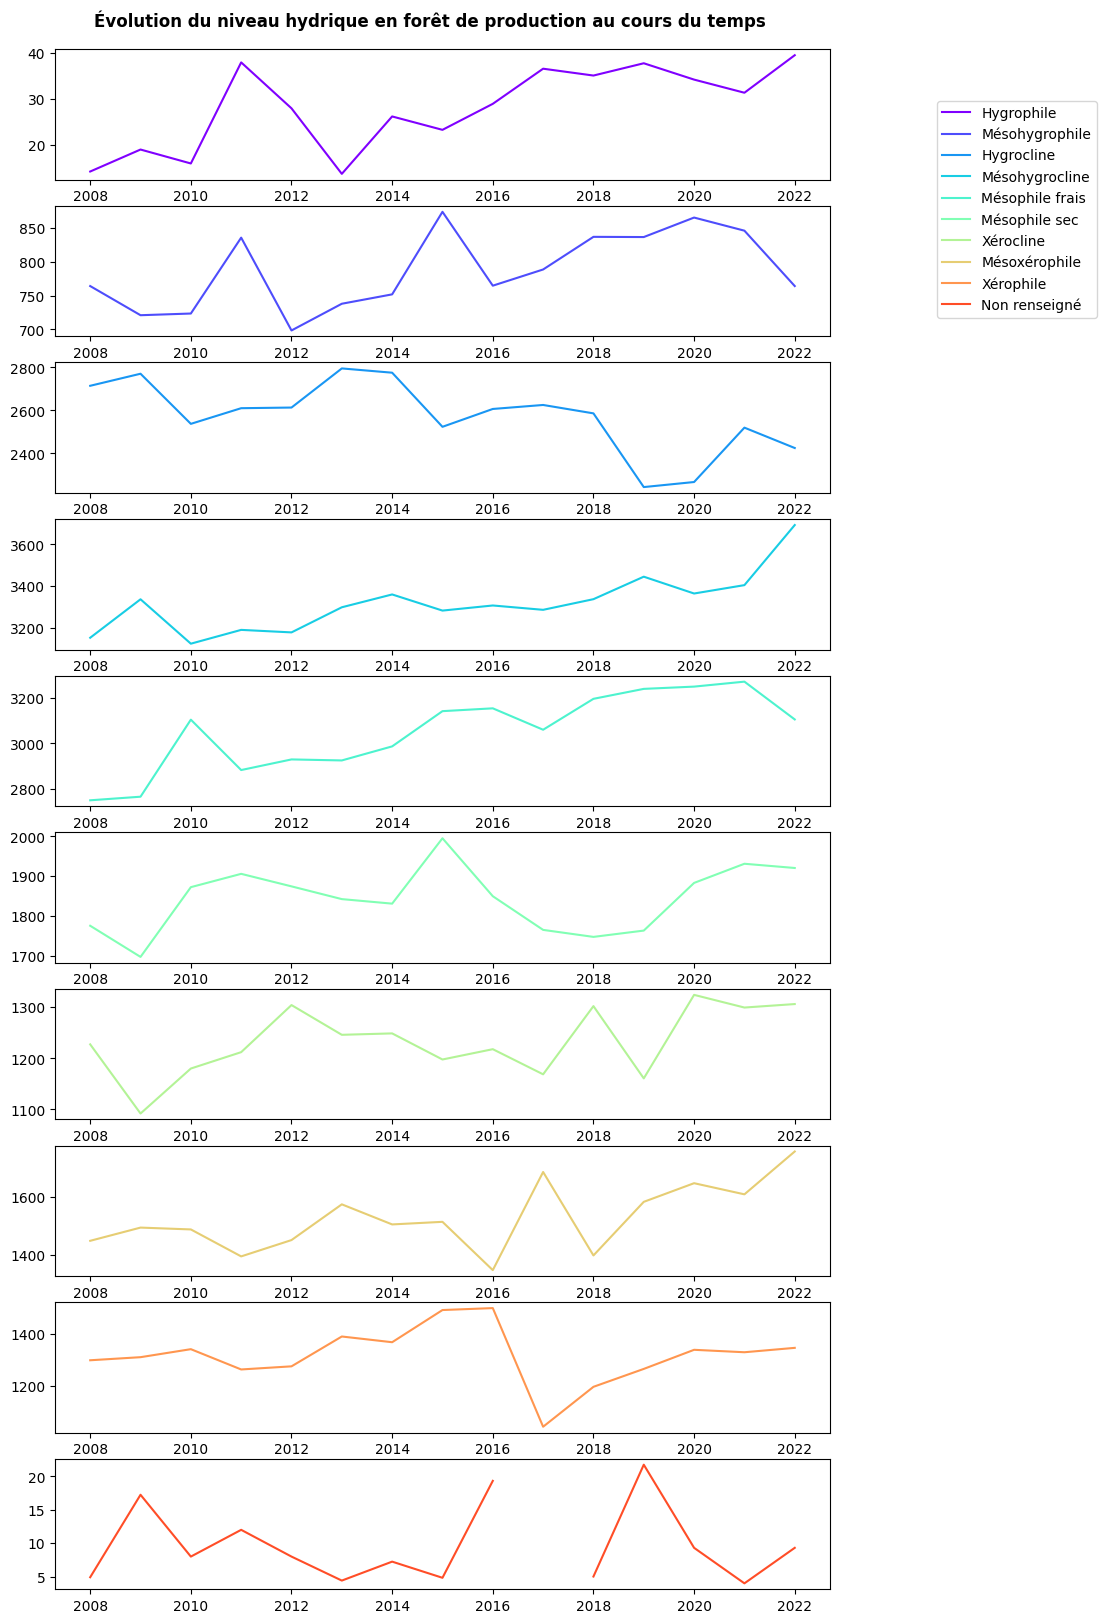

In [41]:
fig = plt.figure(1, figsize=(10, 20))
cm = plt.cm.rainbow
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
    ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du niveau hydrique en forêt de production au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur la sensibilité au tassement

In [42]:
req = f"""SELECT f.incref + 2005 AS campagne, COALESCE(RTRIM(f.sensib_tass), '0') AS sensib_tass, SUM(ue.poids) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
INNER JOIN {SCHEMA}.g3ecologie f USING (npp)
WHERE p2.us_nm = '1'
AND f.incref >= 3
GROUP BY f.incref, sensib_tass
ORDER BY f.incref, sensib_tass
"""

In [43]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,sensib_tass,eff_pond
0,2008,1,4666.275066
1,2008,2,2890.022546
2,2008,3,4522.035279
3,2008,4,2849.625995
4,2008,5,66.802387


In [44]:
reshaped_df = df.pivot(index='campagne', columns='sensib_tass', values='eff_pond')
reshaped_df

sensib_tass,0,1,2,3,4,5,6
campagne,,,,,,,
2008,NaN,4666.275066,2890.022546,4522.035279,2849.625995,66.802387,155.712202
2009,2.206897,4645.310345,2974.775862,4568.938992,2750.423077,88.759947,193.834218
2010,4.000000,4450.500000,3145.000000,4530.500000,3023.666667,80.500000,163.500000
2011,10.000000,4771.500000,2819.000000,4531.000000,2934.000000,67.500000,213.500000
2012,NaN,4695.000000,2922.500000,4633.500000,2862.000000,71.000000,178.000000
2013,4.413793,4714.210803,3084.879255,4740.306285,3021.637862,71.120688,191.811667
2014,7.245283,4540.576885,3234.594387,5003.372940,2787.047211,73.952831,214.952833
2015,28.981133,4642.264217,3175.981178,5081.339697,2901.056646,49.471699,172.150946
2016,53.132076,4419.207611,3041.150988,5176.471773,2888.811363,65.207548,154.566040


In [45]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'SENSIB_TASS'
UNION
SELECT '0', 'Non renseigné'
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,3,Impraticable temporairement – sols non hydromo...
1,2,Praticable avec précaution
2,4,Impraticable temporairement – sols hydromorphes
3,5,Impraticable - sols engorgés
4,6,Impraticable - aulnaie tourbières marais
5,0,Non renseigné
6,1,Praticable


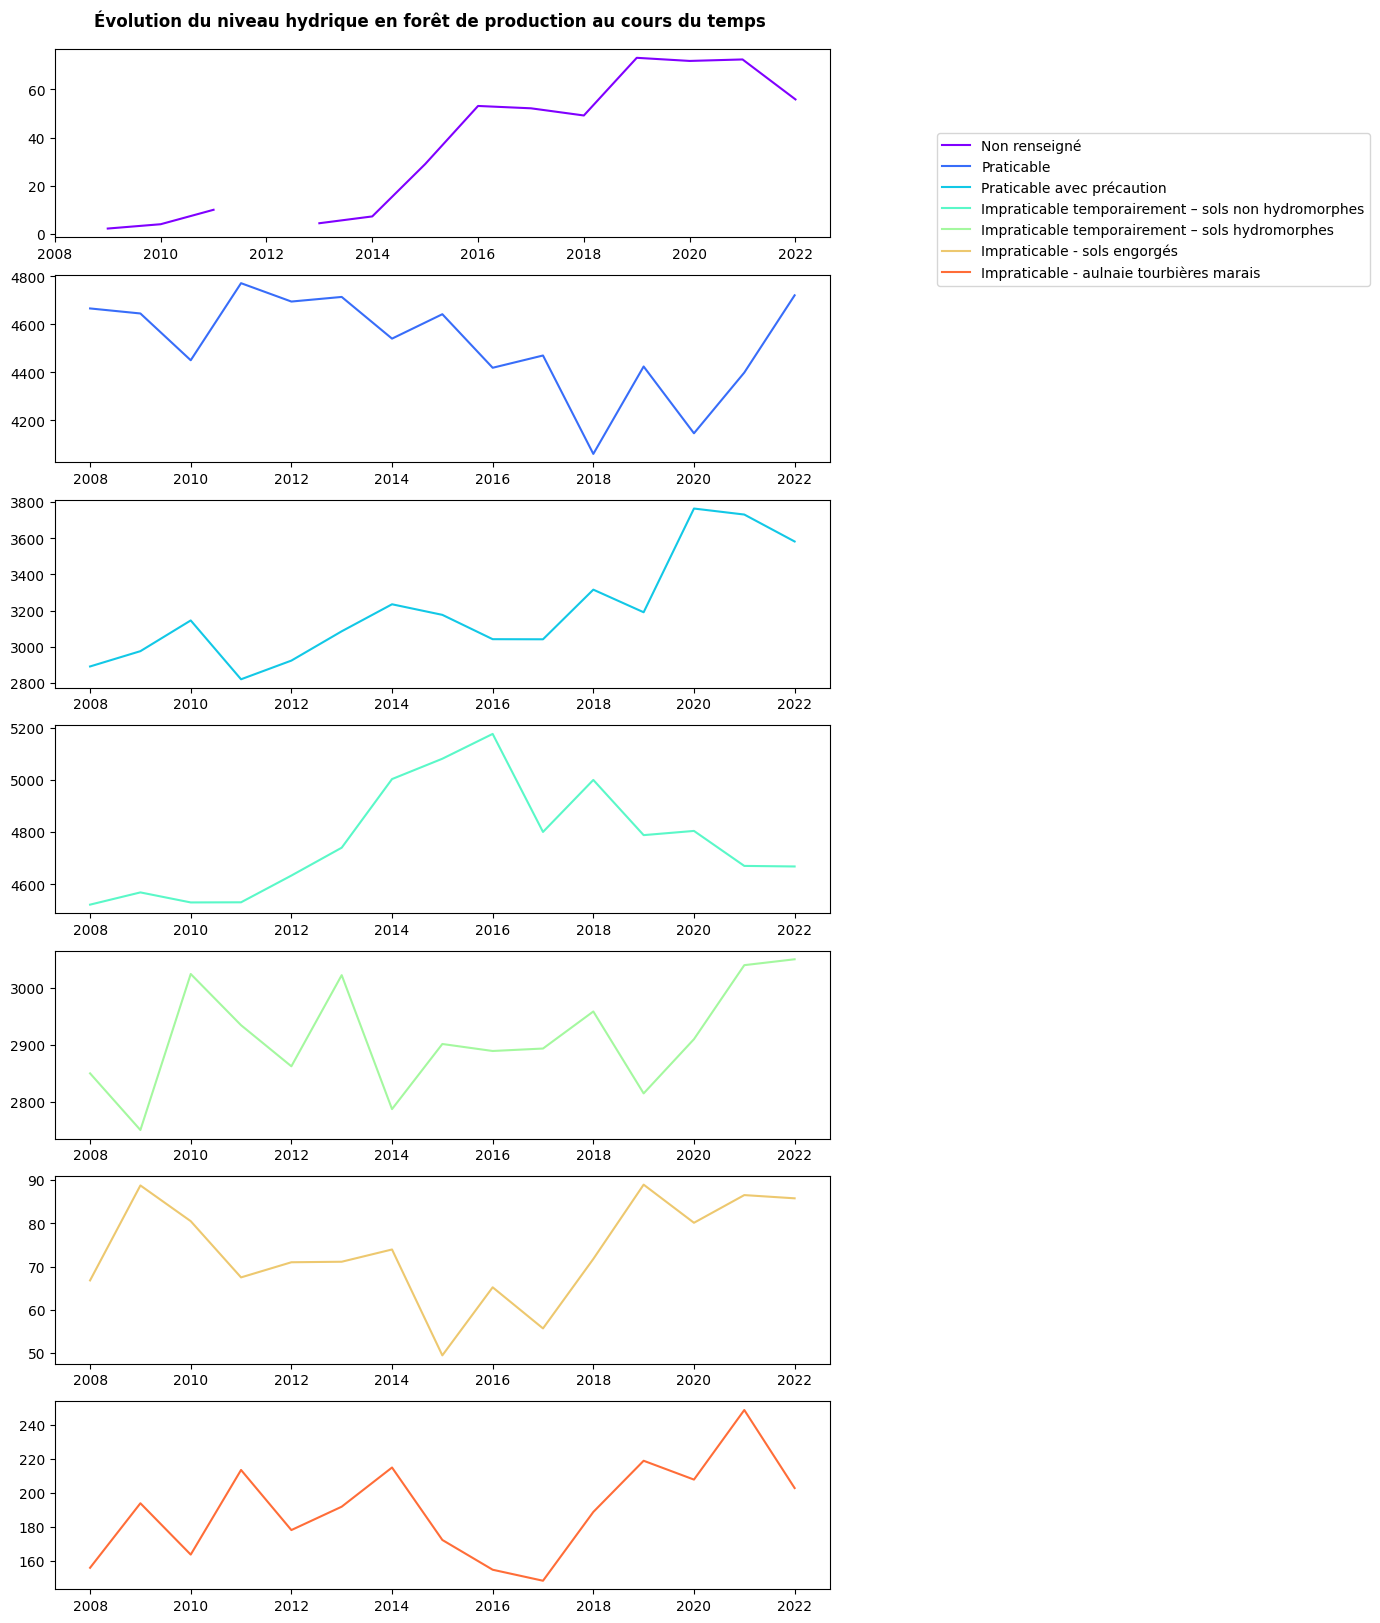

In [46]:
fig = plt.figure(1, figsize=(10, 20))
cm = plt.cm.rainbow
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
    ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du niveau hydrique en forêt de production au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Test sur la propriété

In [3]:
req = f"""SELECT p2.incref + 2005 as campagne, p2.pro_nm, ROUND(SUM(p2.poids)::NUMERIC) AS eff_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
GROUP BY p2.incref, p2.pro_nm
ORDER BY p2.incref, p2.pro_nm
"""

In [4]:
df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,pro_nm,eff_pond
0,2005,1O,1720.0
1,2005,1S,2.0
2,2005,2M,197.0
3,2005,2O,2871.0
4,2005,4I,49934.0


In [5]:
reshaped_df = df.pivot(index='campagne', columns='pro_nm', values='eff_pond')
reshaped_df

pro_nm,1O,1S,2M,2O,2S,4I,CO
campagne,,,,,,,
2005,1720.0,2.0,197.0,2871.0,NaN,49934.0,32.0
2006,1761.0,4.0,201.0,2836.0,NaN,49761.0,38.0
2007,1724.0,8.0,181.0,2802.0,NaN,50832.0,51.0
2008,1715.0,7.0,168.0,2947.0,NaN,50368.0,42.0
2009,1639.0,4.0,203.0,2909.0,NaN,50352.0,69.0
2010,1703.0,3.0,183.0,2908.0,NaN,50313.0,36.0
2011,1710.0,4.0,187.0,2845.0,NaN,50497.0,41.0
2012,1688.0,7.0,195.0,2750.0,NaN,50568.0,59.0
2013,1667.0,6.0,177.0,3002.0,NaN,50172.0,52.0


In [6]:
req = """SELECT mode, libelle
FROM metaifn.abmode
WHERE unite = 'PRO_2015'
"""
meta = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
meta

,mode,libelle
0,2O,Forêt des collectivités et autres établissemen...
1,CO,Forêt de la CT Corse
2,2M,Autre forêt publique en zone militaire
3,4I,Forêt privée
4,1O,Forêt domaniale
5,1S,Forêt de Chambord
6,2S,Autre forêt publique


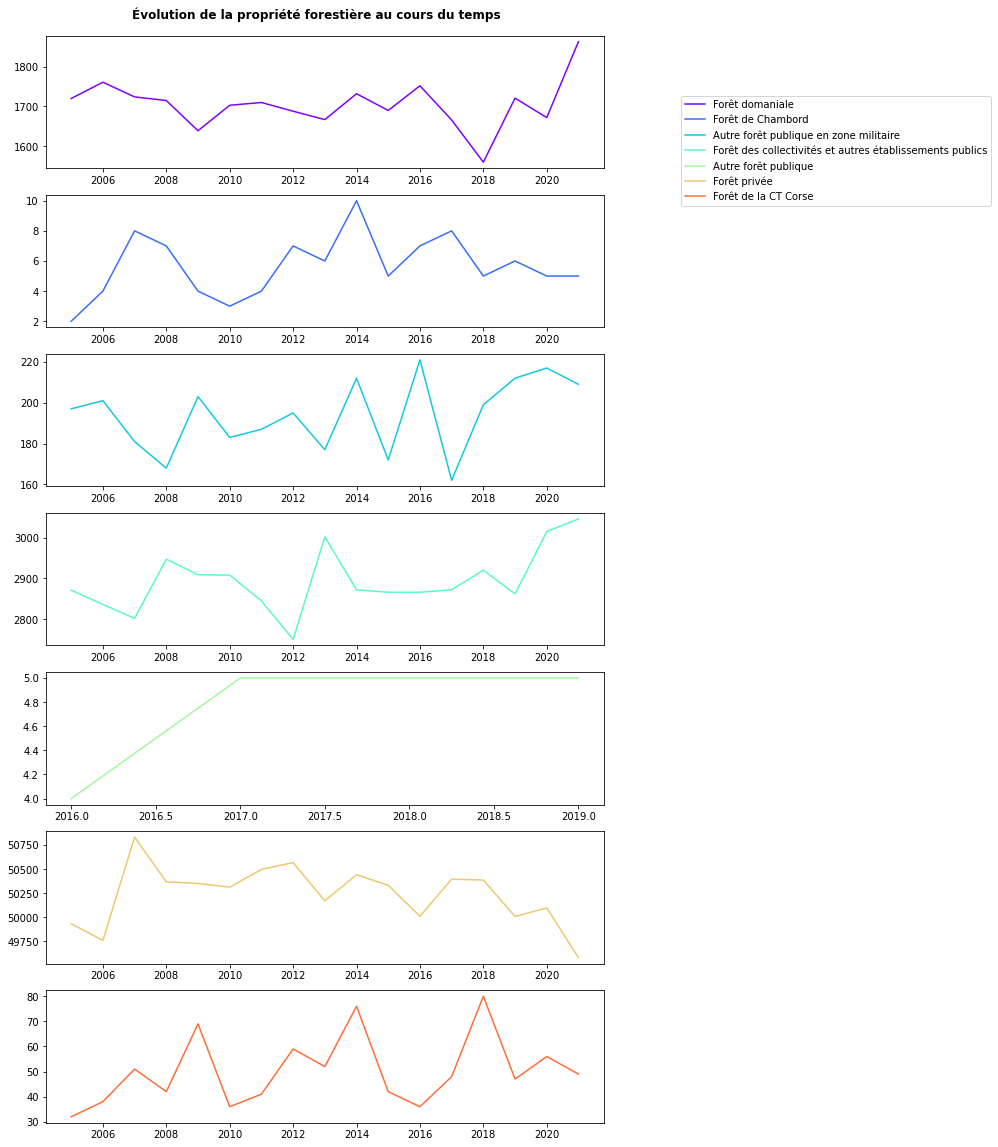

In [63]:
fig = plt.figure(1, figsize=(10, 20))
cm = plt.cm.rainbow
for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
    ax.set_xticks(reshaped_df.index[::2])
    ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de la propriété forestière au cours du temps", y=0.9, fontweight='bold')
plt.show()

# Tests sur surface terrière pondérée

## Arbres vifs

In [47]:
req = f"""SELECT p2.incref + 2005 as campagne, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * a.gtot * ue.poids) AS gtot_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,eff_pond_w,eff_pond_wac,gtot_pond
0,2022,1.154860e+07,1.154902e+07,373896.499790
1,2021,1.127743e+07,1.124770e+07,367409.623222
2,2020,1.100691e+07,1.099195e+07,355772.134058
3,2019,1.080218e+07,1.078095e+07,340659.479744
4,2018,1.122918e+07,1.121654e+07,362453.900734


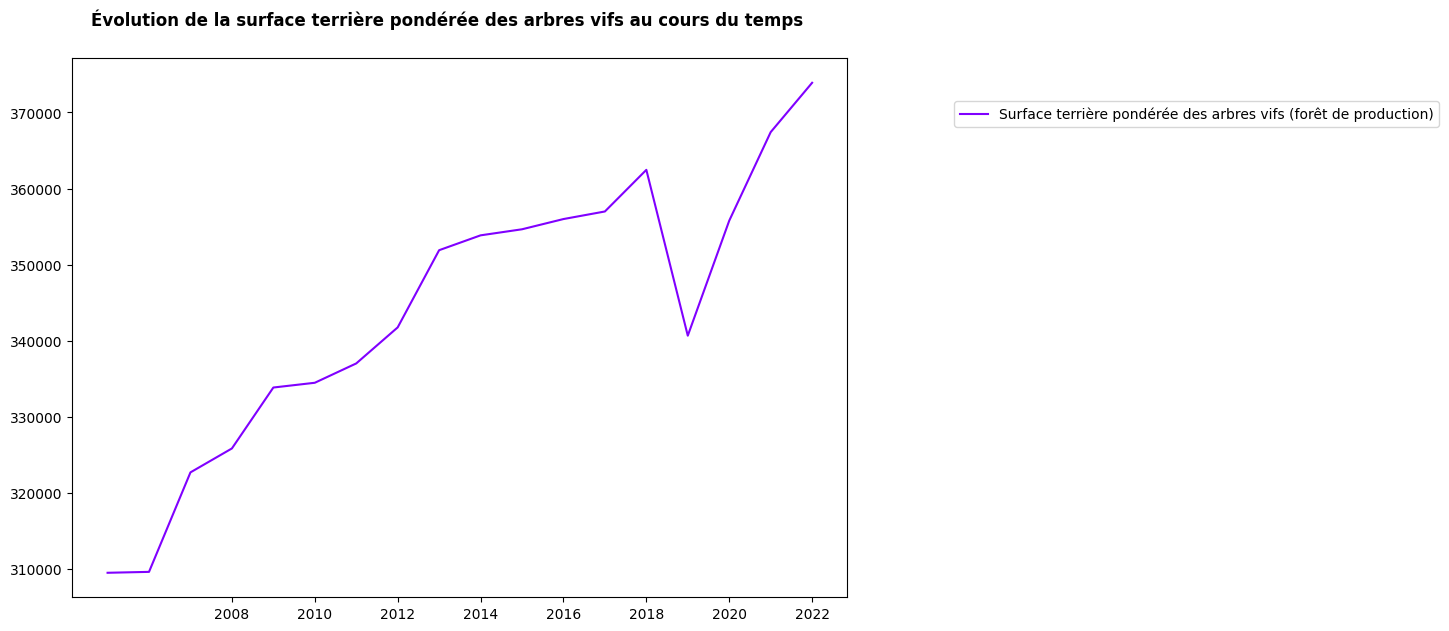

In [49]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['gtot_pond'], label='Surface terrière pondérée des arbres vifs (forêt de production)', color=cm(0))
#for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
#    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
#    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
#    ax.set
ax.set_xticks(reshaped_df.index[::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de la surface terrière pondérée des arbres vifs au cours du temps", y=0.95, fontweight='bold')
plt.show()

## Arbres morts et chablis (première visite)

In [9]:
req = f"""SELECT p2.incref + 2005 as campagne, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * a.gtot * ue.poids) AS gtot_pond
FROM {SCHEMA}.g3morts a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,eff_pond_w,eff_pond_wac,gtot_pond
0,2022,1.293344e+06,1.294244e+06,23736.483217
1,2021,1.267089e+06,1.264264e+06,23060.920063
2,2020,1.173835e+06,1.175413e+06,20712.648555
3,2019,1.069864e+06,1.068131e+06,18096.371524
4,2018,1.084534e+06,1.087753e+06,19328.449890


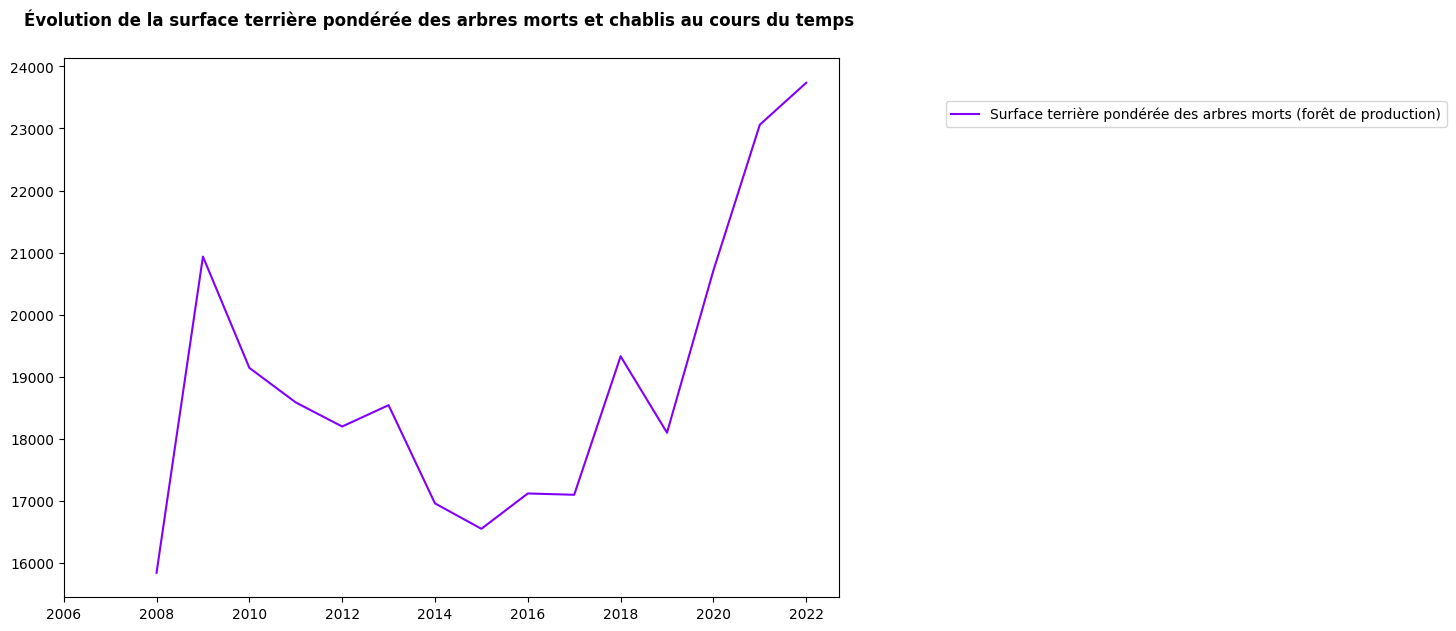

In [11]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['gtot_pond'], label='Surface terrière pondérée des arbres morts (forêt de production)', color=cm(0))
#for k in range(len(reshaped_df.columns)):
#    print(reshaped_df.columns.to_list()[k])
#    print(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])
#    ax = fig.add_subplot(len(reshaped_df.columns), 1, k+1)
#    ax.plot(reshaped_df.index, reshaped_df[reshaped_df.columns[k]], label=list(meta.loc[meta['mode'] == reshaped_df.columns.to_list()[k]]['libelle'])[0], color=cm(1.*k/len(reshaped_df.columns)))      # Or whatever you want in the subplot
#    ax.set
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution de la surface terrière pondérée des arbres morts et chablis au cours du temps", y=0.95, fontweight='bold')
plt.show()

# Test sur le volume estimé

In [12]:
req = f"""SELECT p2.incref + 2005 as campagne, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * ua.u_vest * ue.poids) AS vest_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.u_g3arbre ua USING (npp, a)
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,eff_pond_w,eff_pond_wac,vest_pond
0,2022,1.154860e+07,1.154902e+07,2.868677e+06
1,2021,1.127743e+07,1.124770e+07,2.817842e+06
2,2020,1.100691e+07,1.099195e+07,2.728041e+06
3,2019,1.080218e+07,1.078095e+07,2.612654e+06
4,2018,1.122918e+07,1.121654e+07,2.845568e+06


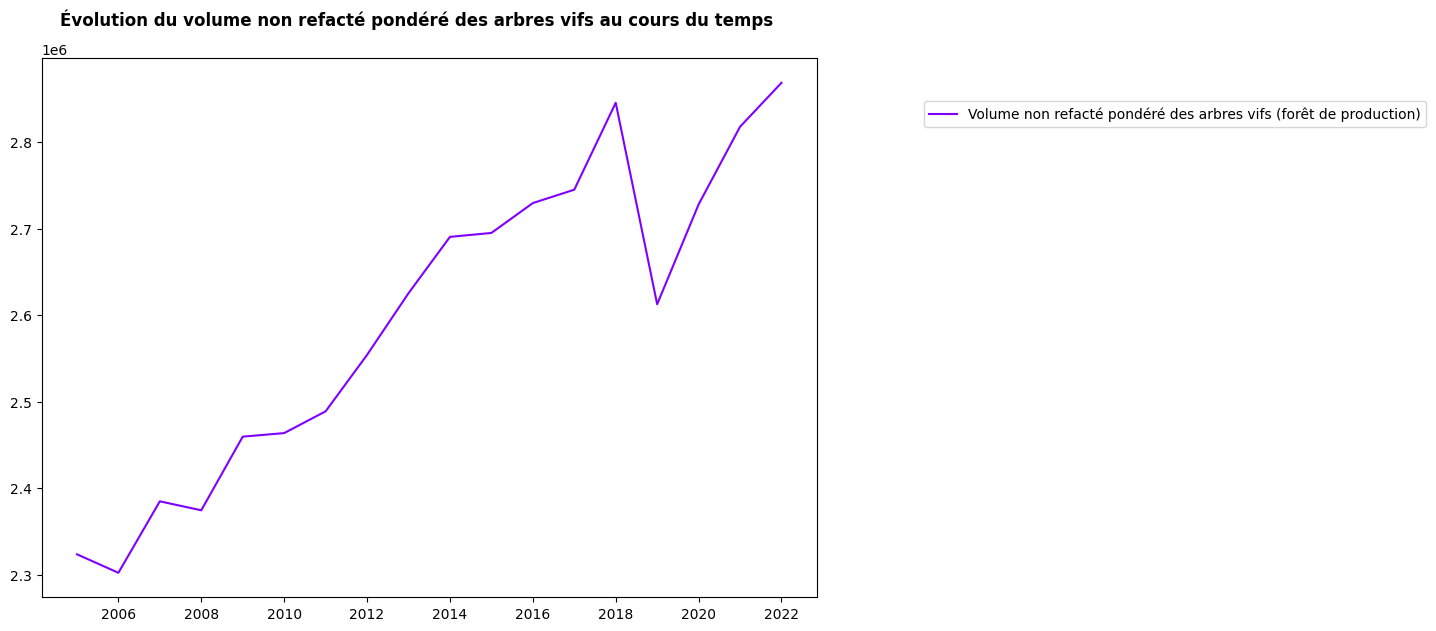

In [13]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['vest_pond'], label='Volume non refacté pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du volume non refacté pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2022)
plt.show()

# Test sur le volume tarifé à une entrée

In [76]:
req = f"""SELECT p2.incref + 2005 as campagne, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * ua.u_v13 * ue.poids) AS vest_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.u_g3arbre ua USING (npp, a)
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,eff_pond_w,eff_pond_wac,vest_pond
0,2021,1.127743e+07,1.124770e+07,2.806741e+06
1,2020,1.100691e+07,1.099195e+07,2.708709e+06
2,2019,1.080218e+07,1.078095e+07,2.581118e+06
3,2018,1.122918e+07,1.121654e+07,2.801741e+06
4,2017,1.136139e+07,1.137455e+07,2.717633e+06


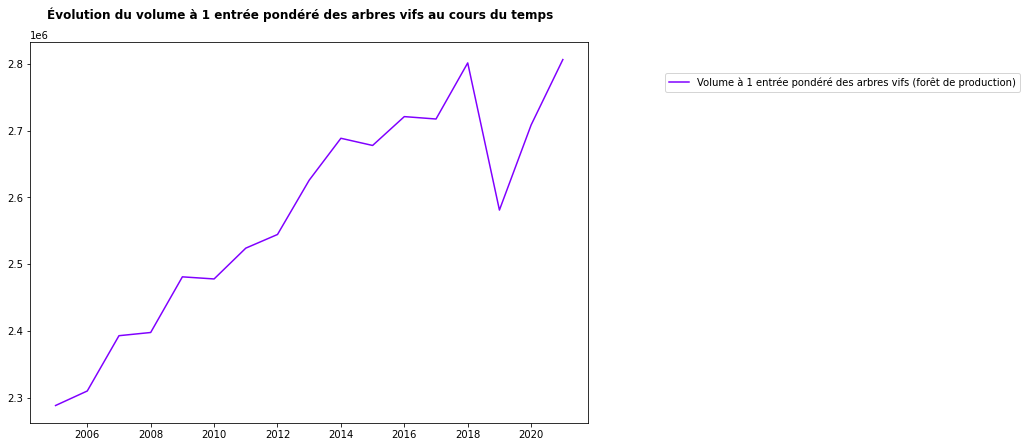

In [77]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['vest_pond'], label='Volume à 1 entrée pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du volume à 1 entrée pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2022)
plt.show()

# Test sur le volume refacté

In [78]:
req = f"""SELECT p2.incref + 2005 as campagne, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * a.v * ue.poids) AS v_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,eff_pond_w,eff_pond_wac,v_pond
0,2021,1.127743e+07,1.124770e+07,2.812724e+06
1,2020,1.100691e+07,1.099195e+07,2.725158e+06
2,2019,1.080218e+07,1.078095e+07,2.607994e+06
3,2018,1.122918e+07,1.121654e+07,2.840035e+06
4,2017,1.136139e+07,1.137455e+07,2.740706e+06


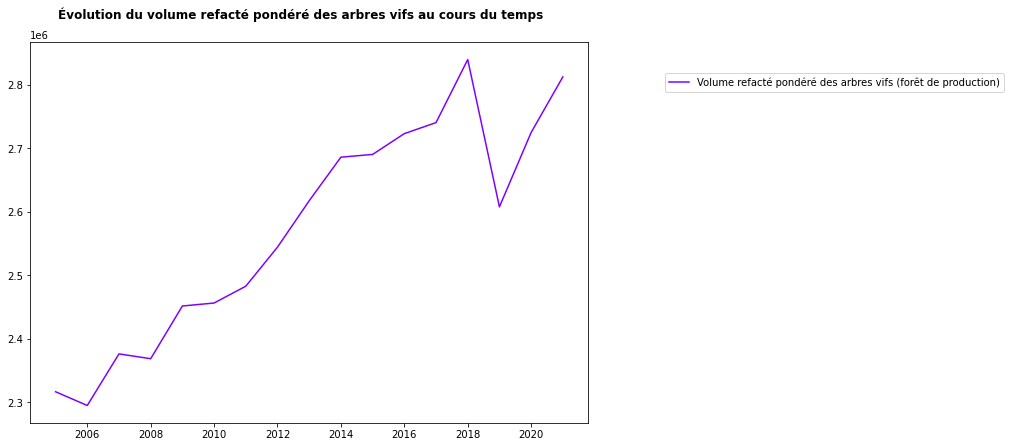

In [80]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['v_pond'], label='Volume refacté pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du volume refacté pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur le volume aérien total

In [81]:
req = f"""SELECT p2.incref + 2005 as campagne, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * ua.u_v0 * ue.poids) AS v0_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.u_g3arbre ua USING (npp, a)
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,eff_pond_w,eff_pond_wac,v0_pond
0,2021,1.127743e+07,1.124770e+07,4.261769e+06
1,2020,1.100691e+07,1.099195e+07,4.092667e+06
2,2019,1.080218e+07,1.078095e+07,3.920912e+06
3,2018,1.122918e+07,1.121654e+07,4.236281e+06
4,2017,1.136139e+07,1.137455e+07,4.089265e+06


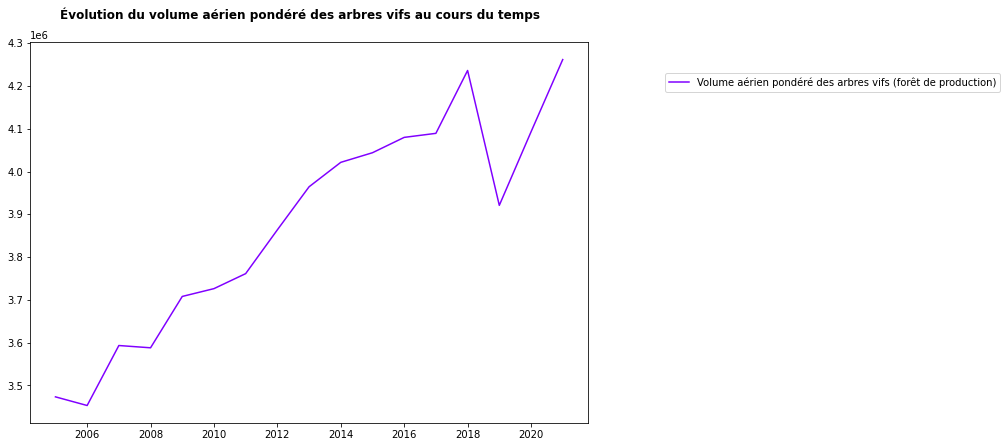

In [82]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['v0_pond'], label='Volume aérien pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Évolution du volume aérien pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

In [83]:
req = f"""SELECT p2.incref + 2005 as campagne, a.ess, sum(a.w * ue.poids) AS eff_pond_w, sum(a.wac * ue.poids) as eff_pond_wac
, sum(a.w * ua.u_v0 * ue.poids) AS v0_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.u_g3arbre ua USING (npp, a)
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne, ess
ORDER BY campagne DESC, v0_pond DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head(20)

,campagne,ess,eff_pond_w,eff_pond_wac,v0_pond
0,2021,02,6.307416e+05,6.258742e+05,552536.215412
1,2021,09,9.442786e+05,9.420225e+05,483622.718464
2,2021,03,6.227029e+05,6.223378e+05,467418.160155
3,2021,61,4.117017e+05,4.103859e+05,304086.816712
4,2021,10,7.072777e+05,7.060013e+05,251190.459348
5,2021,62,3.227535e+05,3.229165e+05,217825.481963
6,2021,11,1.063588e+06,1.063004e+06,211289.778116
7,2021,51,4.759212e+05,4.787203e+05,211112.915926
8,2021,52,4.348842e+05,4.373343e+05,194650.649389
9,2021,05,8.925580e+05,8.921846e+05,173483.222722


In [85]:
df[df["ess"] == '16']

,campagne,ess,eff_pond_w,eff_pond_wac,v0_pond
119,2020,16,2913.527360,2913.527360,189.523327
182,2019,16,427.058895,427.058895,15.212496
243,2018,16,665.681370,665.681370,42.208179
361,2016,16,403.241477,403.241477,223.898858
424,2015,16,75.244658,75.657119,230.533556
485,2014,16,425.309562,450.140022,355.289118
670,2011,16,353.612270,353.612270,69.128556
780,2009,16,761.381203,487.798312,1092.973178
844,2008,16,2254.825374,2249.167394,281.755720
913,2007,16,176.831049,NaN,3.903550


In [86]:
#df.query('campagne == 2020 and v0_pond > 100000')a
print(list(df.loc[(df["campagne"] == 2020) & (df["v0_pond"] > 10**5), "ess"]))
df[df.ess.isin(list(df.loc[(df["campagne"] == 2020) & (df["v0_pond"] > 10**5), "ess"]))]

['02', '09', '03', '61', '10', '62', '52', '51', '05', '11', '17', '64']


,campagne,ess,eff_pond_w,eff_pond_wac,v0_pond
0,2021,02,630741.573652,625874.247232,552536.215412
1,2021,09,944278.631960,942022.539215,483622.718464
2,2021,03,622702.932817,622337.809892,467418.160155
3,2021,61,411701.680343,410385.929130,304086.816712
4,2021,10,707277.661120,706001.330509,251190.459348
...,...,...,...,...,...
979,2005,51,387320.562458,NaN,192698.113097
980,2005,11,912795.604630,NaN,154424.572717
981,2005,05,913529.289832,NaN,153132.929183
982,2005,17,328618.591854,NaN,125879.151285


In [87]:
df2 = df[df.ess.isin(list(df.loc[(df["campagne"] == 2020) & (df["v0_pond"] > 10**5), "ess"]))]
reshaped_df = df2.pivot(index='campagne', columns='ess', values='v0_pond')
reshaped_df

ess,02,03,05,09,10,11,17,51,52,61,62,64
campagne,,,,,,,,,,,,
2005,418910.775996,435852.875872,153132.929183,428493.249482,201031.599362,154424.572717,125879.151285,192698.113097,195416.031410,198354.025702,229402.596213,106379.160943
2006,435455.819530,404595.966789,153583.525247,415783.207965,213721.333668,152530.861051,121904.359555,185725.299582,175882.793205,234544.196637,233401.595376,107918.819741
2007,439065.895528,446667.864982,155137.630341,436908.161779,221667.887744,156331.562774,122240.636623,188709.494602,202613.894155,253056.781406,209987.889385,90944.594619
2008,462514.684201,385495.074556,160439.429801,446901.237554,205878.796076,155492.058601,154558.724130,173250.652700,182317.095533,228218.561600,214484.204989,103203.753686
2009,471777.399736,388481.566893,172791.823512,425976.636923,223478.078992,166460.160472,141377.129751,185780.567200,205213.403900,232607.451247,238712.966739,128248.269272
2010,467137.763648,437047.067735,174192.857173,408725.658352,222404.931528,186960.871410,145239.406008,179852.891994,185046.035787,242848.196448,228045.399313,127469.622367
2011,487712.659960,409627.837205,185602.253744,440061.606219,220298.492962,188578.856496,150892.366710,174399.386551,187723.374747,247801.364176,223128.528793,118691.421953
2012,454427.327129,429877.097594,172493.471947,457960.750958,260792.165831,187232.369554,164512.186166,160008.657288,190017.626418,285373.548635,230778.230043,133723.202115
2013,496030.642737,436698.668684,166541.219430,437194.419382,234159.905057,184754.495259,153069.089574,193293.751432,202105.023624,268552.213280,280045.456695,128598.969261


# Test sur la production en surface terrière

In [3]:
req = f"""SELECT p2.incref + 2005 as campagne
, sum(a.w * a.pg * ue.poids) AS pg_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,pg_pond
0,2021,10477.721835
1,2020,10067.644766
2,2019,10333.289710
3,2018,10822.573863
4,2017,10796.620420


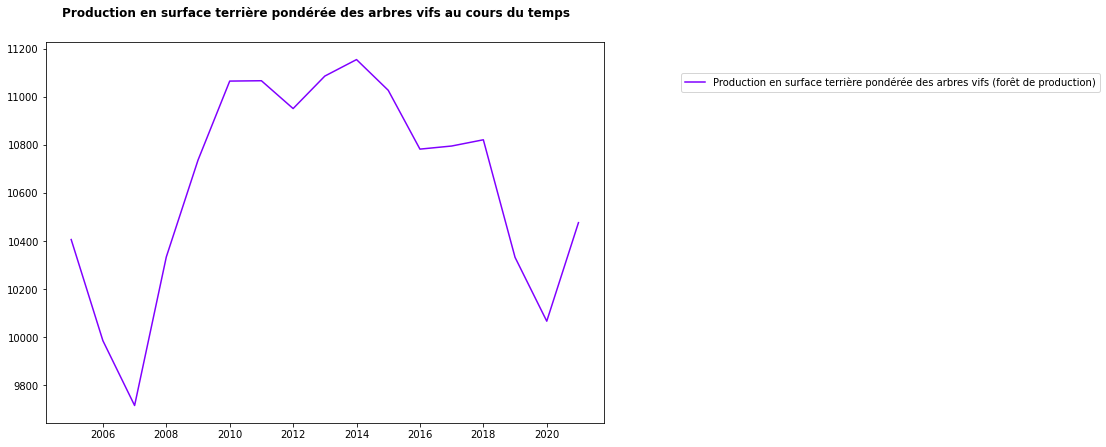

In [4]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['pg_pond'], label='Production en surface terrière pondérée des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Production en surface terrière pondérée des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur le recrutement en surface terrière

In [5]:
req = f"""SELECT p2.incref + 2005 as campagne
, sum(a.w * a.gtot * ue.poids) AS gtot_recrut_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
AND a.rt5 = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,gtot_recrut_pond
0,2021,9351.487925
1,2020,8853.649424
2,2019,10219.405738
3,2018,10002.727608
4,2017,9572.548079


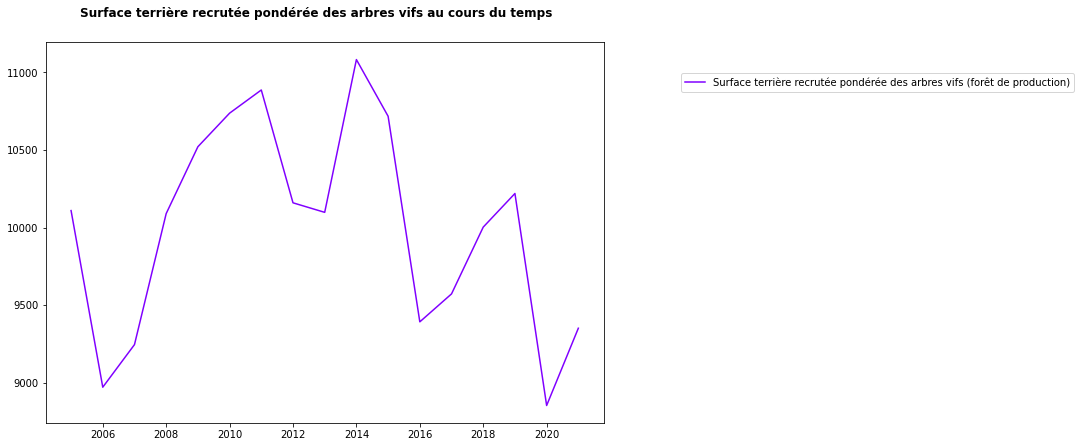

In [6]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['gtot_recrut_pond'], label='Surface terrière recrutée pondérée des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Surface terrière recrutée pondérée des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur IR5

In [7]:
req = f"""SELECT p2.incref + 2005 as campagne
, sum(a.w * a.ir5 * ue.poids) AS ir5_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,ir5_pond
0,2021,81024.106250
1,2020,77262.156257
2,2019,81668.343138
3,2018,83422.457395
4,2017,83614.239450


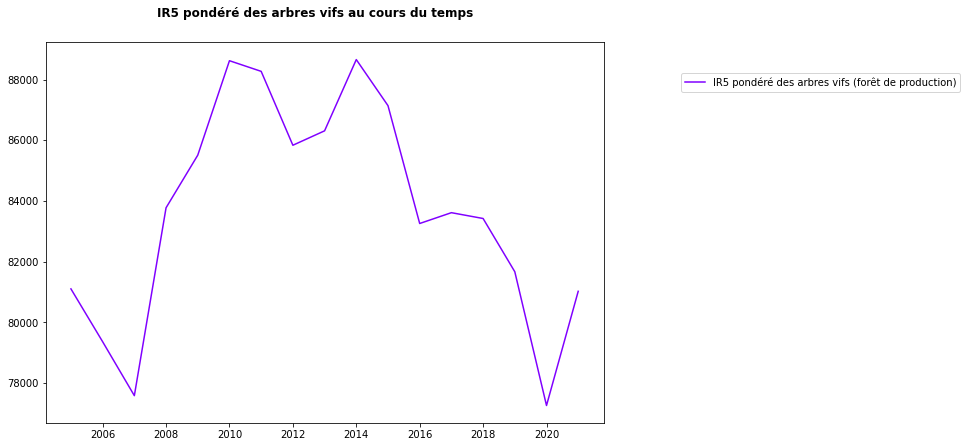

In [8]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['ir5_pond'], label='IR5 pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("IR5 pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur le rebut

In [92]:
req = f"""SELECT p2.incref + 2005 as campagne
, sum(a.w * a.r * ue.poids) AS r_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,r_pond
0,2021,4637.110198
1,2020,2911.309511
2,2019,4054.064607
3,2018,4111.377225
4,2017,4088.635267


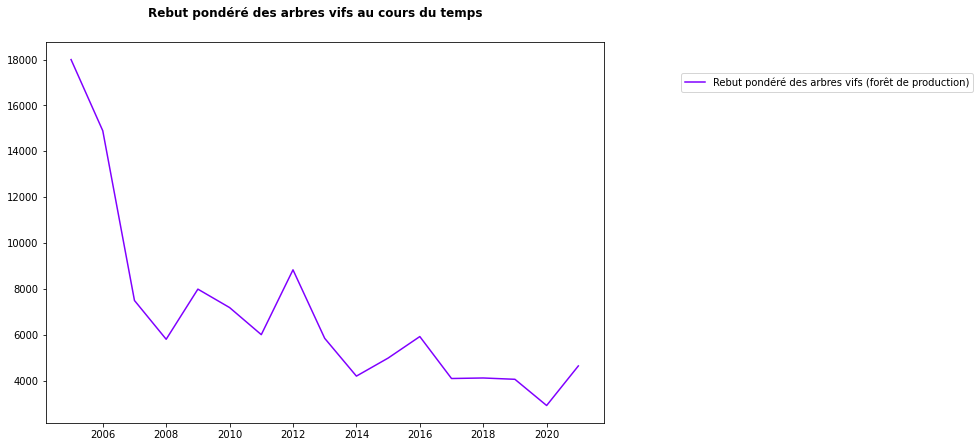

In [93]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['r_pond'], label='Rebut pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Rebut pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur le volume prélevé annualisé

In [9]:
req = f"""SELECT p2.incref + 2010 as campagne
, SUM(p2.poids * ua.u_vpr_an * a.w) AS vpr_an_pond
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.g3arbre a ON p2.npp = a.npp
INNER JOIN {SCHEMA}.u_g3arbre ua ON a.npp = ua.npp AND a.a = ua.a
WHERE p2.incref <= 11
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,vpr_an_pond
0,2021,45089.286528
1,2020,48627.010745
2,2019,45787.583421
3,2018,41972.890927
4,2017,42271.843756


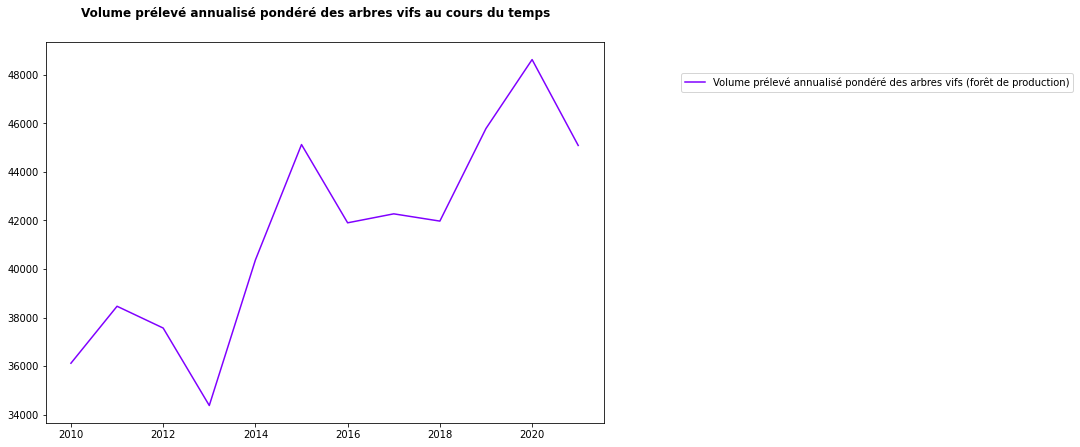

In [5]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['vpr_an_pond'], label='Volume prélevé annualisé pondéré des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Volume prélevé annualisé pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2009, 2021)
plt.show()

# Test sur la production hors effet technique

In [10]:
req = f"""SELECT p2.incref + 2005 as campagne
, sum(a.w * ua.u_pv2 * ue.poids) AS pv2_pond
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.u_g3arbre ua USING (npp, a)
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,pv2_pond
0,2021,79413.606529
1,2020,76677.617555
2,2019,78030.518060
3,2018,84399.287441
4,2017,83486.671535


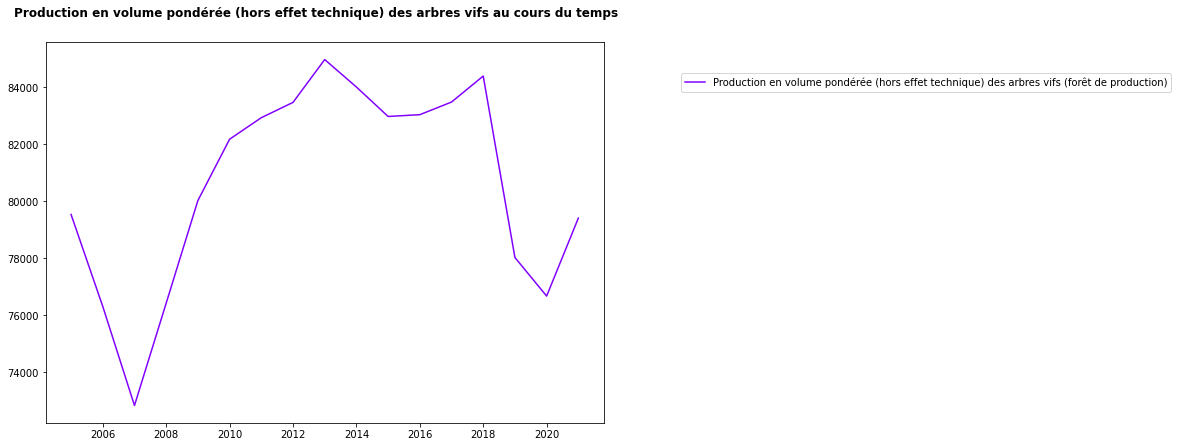

In [11]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['pv2_pond'], label='Production en volume pondérée (hors effet technique) des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Production en volume pondérée (hors effet technique) des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur l'effet technique

In [12]:
req = f"""SELECT p2.incref + 2005 as campagne
, SUM(p2.poids * ua.u_et_an * a.w) AS et
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.g3arbre a ON p2.npp = a.npp
INNER JOIN {SCHEMA}.u_g3arbre ua ON a.npp = ua.npp AND a.a = ua.a
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,et
0,2021,1807.000690
1,2020,2186.055469
2,2019,1674.965212
3,2018,1761.509806
4,2017,1825.049627


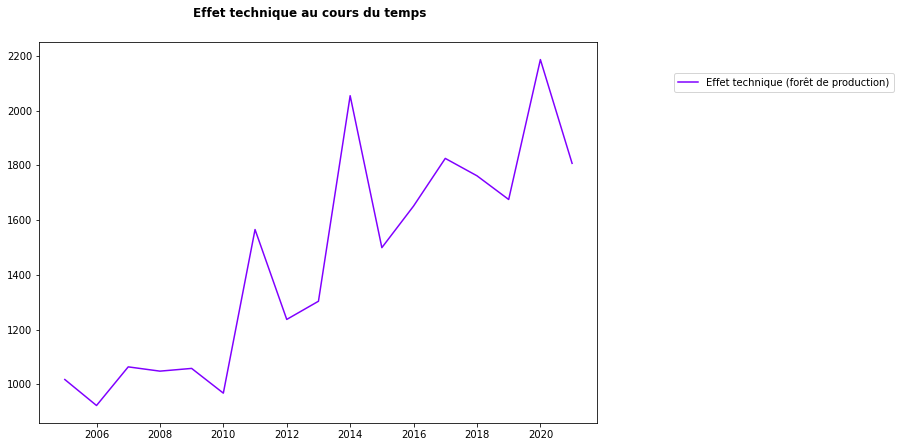

In [13]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['et'], label='Effet technique (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Effet technique au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur la production avec effet technique

In [14]:
req = f"""SELECT p2.incref + 2005 as campagne
, SUM(p2.poids * a.pv * a.w) AS pv
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.g3arbre a ON p2.npp = a.npp
WHERE p2.us_nm = '1'
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,pv
0,2021,81223.119411
1,2020,78892.324308
2,2019,79711.277046
3,2018,84405.342976
4,2017,83625.355221


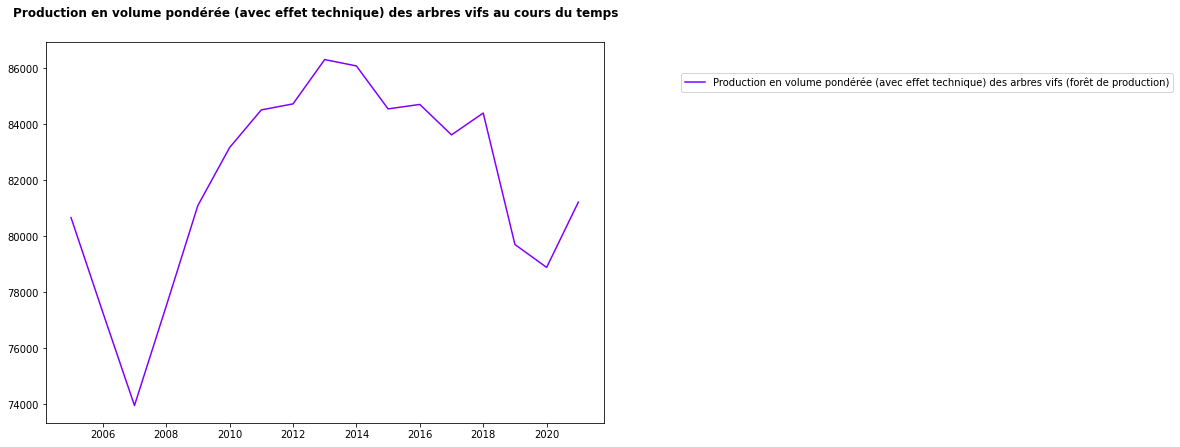

In [15]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['pv'], label='Production en volume pondérée (avec effet technique) des arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Production en volume pondérée (avec effet technique) des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2004, 2021)
plt.show()

# Test sur le volume prélevé annualisé actualisé

In [18]:
req = f"""SELECT p2.incref + 2010 as campagne
, sum(p2.poids * a.w * a.vpr_an_act) as vpr_an_act
FROM {SCHEMA}.e2point p2
INNER JOIN {SCHEMA}.g3arbre a ON p2.npp = a.npp
WHERE p2.incref <= 11
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df.head()

,campagne,vpr_an_act
0,2021,48781.576435
1,2020,52630.713805
2,2019,49715.695520
3,2018,45699.010830
4,2017,46050.566080


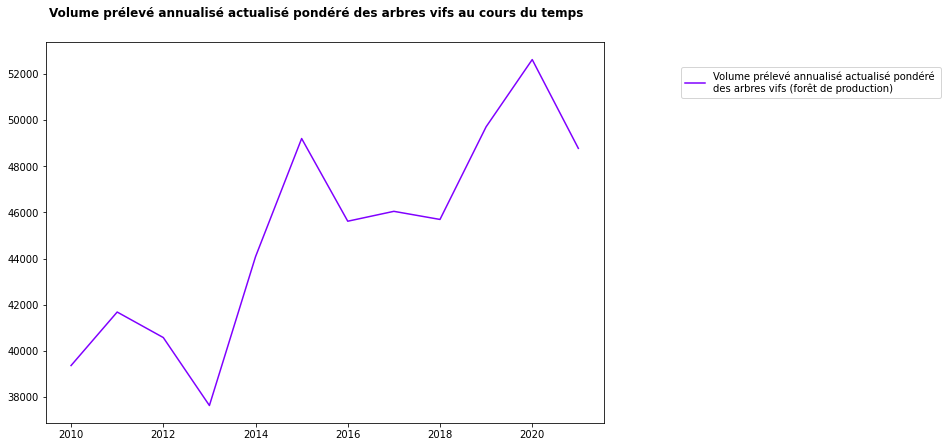

In [19]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['vpr_an_act'], label='Volume prélevé annualisé actualisé pondéré \ndes arbres vifs (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Volume prélevé annualisé actualisé pondéré des arbres vifs au cours du temps", y=0.95, fontweight='bold')
#ax.set_xlim(2009, 2021)
plt.show()

## Arbres morts et chablis (deuxième visite)

In [37]:
req = f"""SELECT p2.incref + 2010 as campagne
, sum(a.vmort_an * a.w * ue.poids) AS vmort_an
, sum(a.gmort_an * a.w * ue.poids) AS gmort_an
, sum(a.vchab_an * a.w * ue.poids) AS vchab_an
, sum(a.gchab_an * a.w * ue.poids) AS gchab_an
FROM {SCHEMA}.g3arbre a
INNER JOIN {SCHEMA}.e2point p2 USING (npp)
INNER JOIN {SCHEMA}.unite_ech ue ON p2.id_unite = ue.id_unite
INNER JOIN {SCHEMA}.echantillon e ON ue.id_ech = e.id_ech AND e.usite = 'P' AND e.format = 'TE2POINT'
WHERE p2.us_nm = '1'
AND p2.incref BETWEEN 5 AND 11
GROUP BY campagne
ORDER BY campagne DESC;
"""

df = pd.read_sql_query(con=engine.connect(), sql=sql_text(req))
df

,campagne,vmort_an,gmort_an,vchab_an,gchab_an
0,2021,14715.030748,2228.850491,4344.427775,623.741544
1,2020,12521.759073,2000.763673,4187.305334,625.206684
2,2019,11107.187096,1756.921526,3094.107742,453.701195
3,2018,9218.569302,1516.847161,3379.144683,503.614300
4,2017,8162.363674,1322.816517,2686.363046,391.302215
5,2016,7912.403928,1284.167104,3055.555144,444.111617
6,2015,7505.999822,1230.614968,2493.812412,374.239085


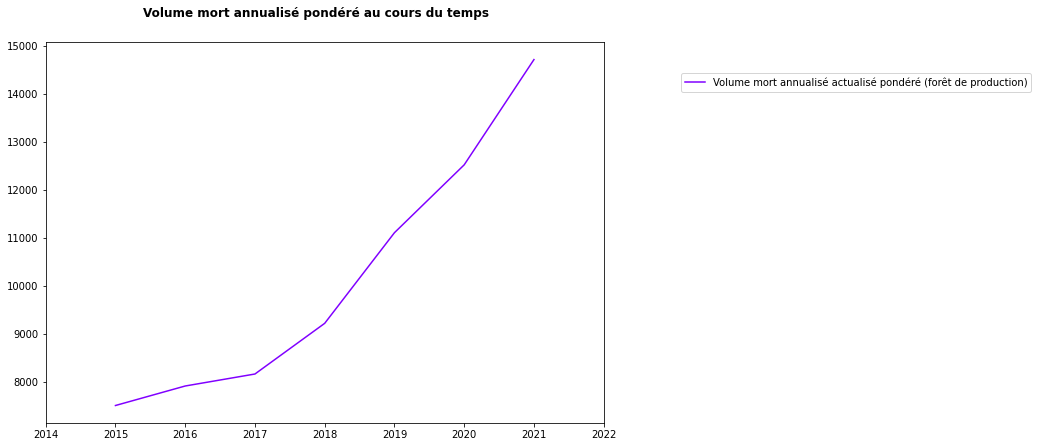

In [38]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['vmort_an'], label='Volume mort annualisé actualisé pondéré (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Volume mort annualisé pondéré au cours du temps", y=0.95, fontweight='bold')
ax.set_xlim(2014, 2022)
plt.show()

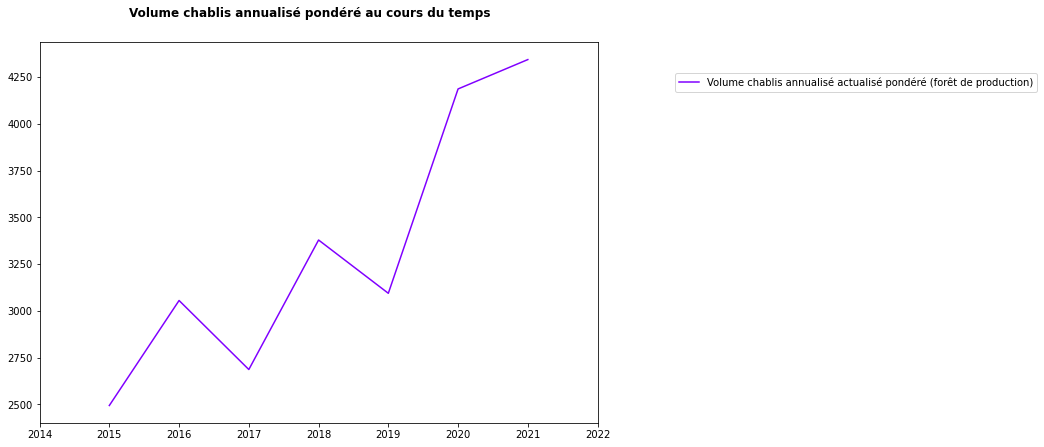

In [39]:
fig = plt.figure(1, figsize=(10, 7))
cm = plt.cm.rainbow
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['campagne'], df['vchab_an'], label='Volume chablis annualisé actualisé pondéré (forêt de production)', color=cm(0))
ax.set_xticks(df['campagne'][::2])
ax.set
fig.legend(loc='center left', bbox_to_anchor=(1, 0.8))
fig.suptitle("Volume chablis annualisé pondéré au cours du temps", y=0.95, fontweight='bold')
ax.set_xlim(2014, 2022)
plt.show()

In [30]:
if engine is not None:
    engine.dispose()